In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from matplotlib import patheffects as pe


In [2]:
# =========================
# Settings / paths
# =========================
dir_savefig = '/burg/home/rg3390/analysis/veg_air_T/'

# =========================
# Physical constants
# =========================
sigma   = 5.67e-8      # W m^-2 K^-4
Cp      = 1004.0       # J kg^-1 K^-1
Lv      = 2.5e6        # J kg^-1
epsilon = 0.95         # LW emissivity
eps_q   = 0.622        # ratio of gas constants
Rd      = 287.0        # J kg^-1 K^-1


In [3]:
# =========================
# Thermodynamics helpers
# =========================
def saturation_vapor_pressure_cc(T_C):
    """Clausius–Clapeyron saturation vapor pressure (Pa) at temperature (°C)."""
    T_K = T_C + 273.15
    e0 = 611.0
    Rv = 461.0
    return e0 * np.exp((Lv / Rv) * (1.0/273.15 - 1.0/T_K))

def delta_svp_cc(T_C):
    """Slope of saturation vapor pressure curve (Pa K^-1)."""
    T_K = T_C + 273.15
    e_s = saturation_vapor_pressure_cc(T_C)
    Rv = 461.0
    return (Lv * e_s) / (Rv * T_K**2)

def saturation_specific_humidity_cc(T_C, pressure=101000.0):
    """Saturation specific humidity (kg kg^-1)."""
    e_s = saturation_vapor_pressure_cc(T_C)
    return eps_q * e_s / (pressure - (1.0 - eps_q) * e_s)

def dqs_dT(T_C, pressure=101000.0):
    """d(qs)/dT (kg kg^-1 K^-1) at (T, P)."""
    e_s  = saturation_vapor_pressure_cc(T_C)
    delt = delta_svp_cc(T_C)
    num  = eps_q * pressure
    den  = (pressure - (1.0 - eps_q) * e_s)**2
    return (num / den) * delt

def f_soil_moisture(sm, sm_wilt=0.15, sm_fc=0.40):
    """Linear soil moisture stress (0..1)."""
    return np.clip((sm - sm_wilt) / (sm_fc - sm_wilt), 1e-6, 1.0)

# =========================
# iterate air density (ρ), taking PRESSURE as input
# =========================
def iterate_rho(T_C, pressure, RH=None, use_RH_for_rho=False,
                rho_init=1.15, tol=1e-4, max_iter=20):
    """
    Iteratively solve for air density using:  p = ρ * Rd * Tv,
    Tv = T * (1 + 0.61 * q), with either q = qs(T, p) [default]
    or q = RH * qs(T, p) if use_RH_for_rho=True and RH provided.

    Returns: rho [kg m^-3]
    """
    rho = float(rho_init)
    T_K = T_C + 273.15
    for _ in range(max_iter):
        qs = saturation_specific_humidity_cc(T_C, pressure)
        q_use = (RH * qs) if (use_RH_for_rho and (RH is not None)) else qs
        Tv = T_K * (1.0 + 0.61 * q_use)
        rho_new = pressure / (Rd * Tv)
        if abs(rho_new - rho) < tol:
            rho = rho_new
            break
        rho = rho_new
    return float(rho)

In [4]:
# =========================
# Core model (uses pressure input; iterates ρ if requested)
# =========================
def ts_minus_ta_model(
    RH, SWdn, LWdn, Ta_C, LAI, ra, SM, rs_min, alpha,
    pressure, rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
    rho_init=1.15, include_LWup_in_base=True
):
    """
    Compute Ts - Ta (°C) using a linearized surface energy balance around Ta.

    Required:
      pressure [Pa] is now an input.
    Density:
      If iterate_rho_flag=True or rho is None, ρ is obtained via iterate_rho(Ta, pressure, ...).
      Else, the provided rho is used.
    """
    # Air density ρ
    if iterate_rho_flag or (rho is None):
        rho = iterate_rho(Ta_C, pressure, RH=RH if np.isscalar(RH) else None,
                          use_RH_for_rho=use_RH_for_rho, rho_init=rho_init)
    # Resistances
    fsm = f_soil_moisture(SM)
    rs  = rs_min / (LAI * fsm)
    ra  = np.maximum(ra, 1e-6)
    rs  = np.maximum(rs, 1e-6)

    # Thermodynamics at Ta (note: pressure is fixed, ρ may vary with Ta)
    T_K   = Ta_C + 273.15
    qs    = saturation_specific_humidity_cc(Ta_C, pressure)   # kg/kg
    dqsDT = dqs_dT(Ta_C, pressure)                            # kg/kg/K
    qa    = RH * qs

    # Denominator A (∂Flux/∂Ts at Ts≈Ta)
    A = (4.0 * epsilon * sigma * T_K**3) + (rho * Lv * dqsDT) / (ra + rs) + (rho * Cp) / ra

    # Base Rn and evaporation at Ta
    LWup_at_Ta = epsilon * sigma * T_K**4 if include_LWup_in_base else 0.0
    Rn_base    = (1.0 - alpha) * SWdn + LWdn - LWup_at_Ta
    evap_base  = (rho * Lv / (ra + rs)) * (qs - qa)  # W m^-2

    # Linearized solution
    dT = (Rn_base - evap_base) / A
    return dT, Rn_base, evap_base


In [5]:
# =========================
# Plotting helper (centered grid)
# =========================
def centers_to_edges(x):
    x = np.asarray(x)
    dx = np.diff(x)
    first = x[0] - dx[0]/2.0
    last  = x[-1] + dx[-1]/2.0
    mids  = 0.5 * (x[1:] + x[:-1])
    return np.concatenate([[first], mids, [last]])

# =========================
# Printing helper (find x when y is crossing 0)
# =========================
def _zero_crossings(x, y):
    x = np.asarray(x); y = np.asarray(y)
    roots = []
    finite = np.isfinite(y)
    for i in range(len(x) - 1):
        if not (finite[i] and finite[i+1]):
            continue
        yi, yj = y[i], y[i+1]
        if yi == 0.0:                 # exact zero at a grid point
            roots.append(float(x[i]))
        elif yi * yj < 0.0:           # sign change → interpolate
            roots.append(float(x[i] - yi * (x[i+1] - x[i]) / (yj - yi)))
    # check last point exact zero
    if finite[-1] and y[-1] == 0.0:
        roots.append(float(x[-1]))
    # de-duplicate nearly-identical roots
    if roots:
        roots = np.unique(np.round(roots, 4)).tolist()
    return roots


In [6]:
# =========================
# Common plotting style
# =========================
AX_LABEL_FS    = 18
TITLE_FS       = 18
TICK_LABEL_FS  = 18
MAJOR_TICK_LEN = 9
MINOR_TICK_LEN = 5
TICK_WIDTH     = 1.6

Iterated air density ρ (kg m^-3) using pressure=1010.0 hPa and saturation q:
  Ta = 10.0 °C  ->  ρ = 1.2371 kg m^-3
  Ta = 20.0 °C  ->  ρ = 1.1898 kg m^-3
  Ta = 30.0 °C  ->  ρ = 1.1419 kg m^-3
Saved png: fig_3_theory_Ts_minus_Ta_RH_SM_Ta_SWdn_iterRho_v1.png


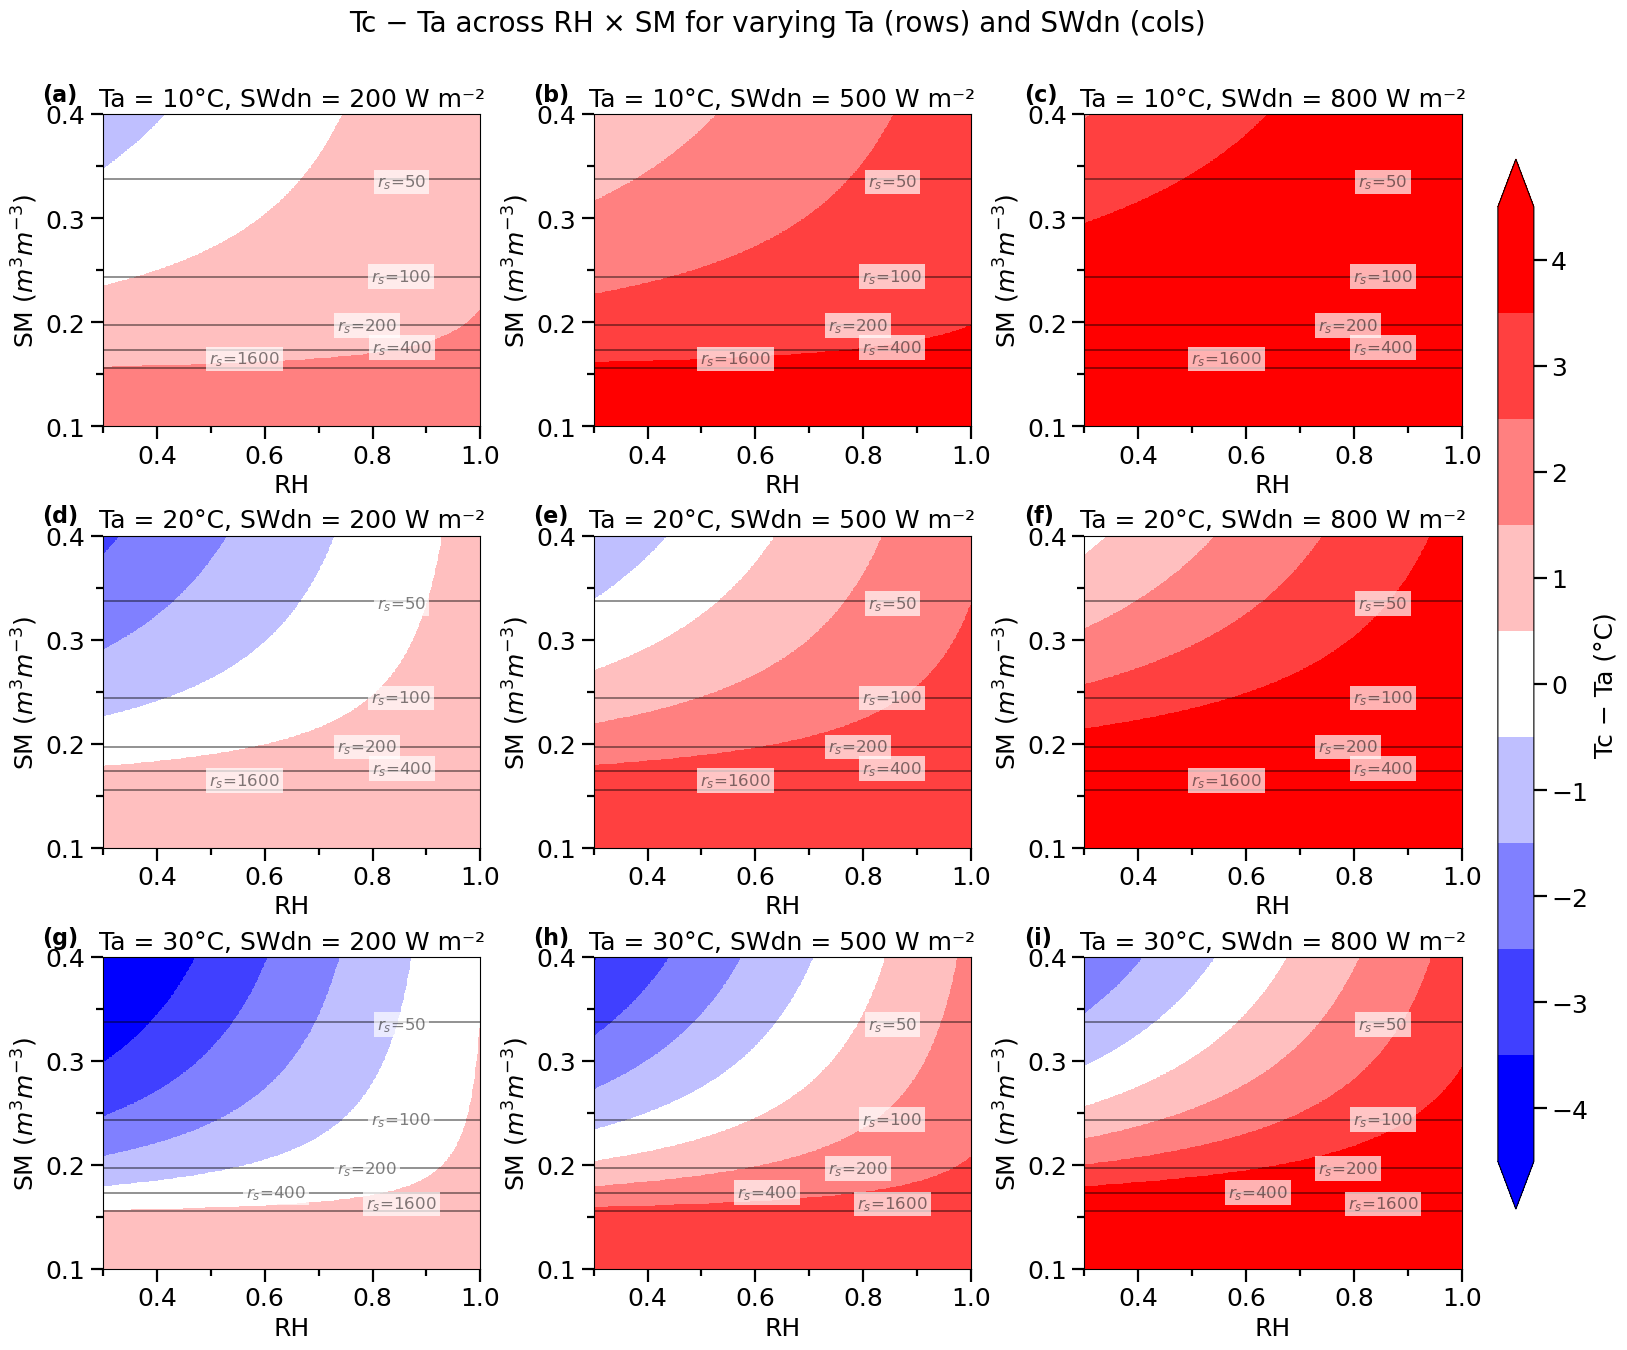

In [7]:
# =========================
# User-defined inputs: FIGURE 1 (RH × SM; rows=Ta, cols=SWdn)
# =========================
LAI_input       = 4.0          # [-]
ra_input        = 10.0         # s m^-1
rs_min_input    = 150.0        # s m^-1 (leaf min)
alpha_input     = 0.10         # [-]
pressure_input  = 101000.0     # Pa (NOW the driver)
LWdn_fixed      = 375.0        # W m^-2

# Grids (centers)
RH_vals = np.linspace(0.30, 1.00, 500)
SM_vals = np.linspace(0.10, 0.40, 500)
RH_grid, SM_grid = np.meshgrid(RH_vals, SM_vals)
# Edges for centered cells
RH_edges = centers_to_edges(RH_vals)
SM_edges = centers_to_edges(SM_vals)

# Sweep lists (rows: Ta; cols: SWdn)
Ta_list   = [10.0, 20.0, 30.0]       # °C
SWdn_list = [200.0, 500.0, 800.0]    # W m^-2

# ===== Print iterated densities once (for the Ta list) =====
print(f"Iterated air density ρ (kg m^-3) using pressure={pressure_input/100:.1f} hPa and saturation q:")
for Ta in Ta_list:
    rho_iter = iterate_rho(Ta, pressure_input, RH=None, use_RH_for_rho=False, rho_init=1.15)
    print(f"  Ta = {Ta:>4.1f} °C  ->  ρ = {rho_iter:.4f} kg m^-3")

# =========================
# FIGURE 1: Ts-Ta + rs contours
# =========================
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.subplots_adjust(right=0.88, wspace=0.30, hspace=0.35)

vmin, vmax = -4.5, 4.5
n_color = 9
levels_ticks = np.linspace(-4, 4, n_color)

# rs contour levels (s m^-1)
rs_levels = [50, 100, 200, 400, 1600]

for r, Ta in enumerate(Ta_list):
    for c, SWdn in enumerate(SWdn_list):
        ax = axes[r, c]

        # Ts - Ta field (iterate ρ internally)
        Ts_minus_Ta, Rn, airD = ts_minus_ta_model(
            RH=RH_grid, SWdn=SWdn, LWdn=LWdn_fixed, Ta_C=Ta,
            LAI=LAI_input, ra=ra_input, SM=SM_grid, rs_min=rs_min_input,
            alpha=alpha_input, pressure=pressure_input,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )

        # Base pcolormesh
        pcm = ax.pcolormesh(
            RH_edges, SM_edges, Ts_minus_Ta,
            cmap=plt.get_cmap('bwr', n_color),
            shading='auto', vmin=vmin, vmax=vmax
        )

        # ---- rs contour overlay (rs depends on SM only here) ----
        fsm = f_soil_moisture(SM_grid)
        rs_canopy = rs_min_input / (LAI_input * fsm)    # s m^-1
        rs_plot = np.clip(rs_canopy, 0, 2000)

        cs = ax.contour(
            RH_grid, SM_grid, rs_plot,
            levels=rs_levels, colors='k', linewidths=1.2, alpha=0.5
        )
        # Draw labels without inlining so lines remain continuous
        cl = ax.clabel(cs, fmt=r"$r_s$=%d", inline=False, fontsize=12, colors='k')
        
        # Solid white box behind each label (square or rounded)
        for txt in cl:
            txt.set_bbox(dict(
                boxstyle="square,pad=0.18",   # try "round,pad=0.22" for rounded corners
                facecolor="white",
                edgecolor="none",             # or a thin outline: edgecolor="0.7", linewidth=0.5
                linewidth=0.0,
                alpha=0.7                     # tweak if you want a hint of the line to show through
            ))
            # Keep everything inside the subplot and above the contours
            txt.set_clip_on(True)
            txt.set_clip_path(ax.patch)
            txt.set_zorder(3)
        
        # --- Pull labels inward if too close to the edges (continuity preserved) ---
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        mx = 0.20 * (x1 - x0)   # 3% margins
        my = 0.20 * (y1 - y0)
        cx, cy = 0.5*(x0+x1), 0.5*(y0+y1)
        
        for txt in cl:
            x, y = txt.get_position()
            nx, ny = x, y
        
            # clamp into a safe inset box
            if x < x0 + mx: nx = x0 + mx
            if x > x1 - mx: nx = x1 - mx
            if y < y0 + my: ny = y0 + my
            if y > y1 - my: ny = y1 - my
        
            # gentle nudge toward subplot center so labels don't hug the edge
            if (nx != x) or (ny != y):
                vx, vy = cx - nx, cy - ny
                L = (vx**2 + vy**2)**0.5 or 1.0
                extra = 0.01 * max(x1 - x0, y1 - y0)  # 1% of axis span
                nx += extra * vx / L
                ny += extra * vy / L
        
            txt.set_position((nx, ny))

        # Labels / ticks
        ax.set_title(f"Ta = {Ta:.0f}°C, SWdn = {SWdn:.0f} W m⁻²", fontsize=TITLE_FS)
        ax.set_xlabel("RH", fontsize=AX_LABEL_FS)
        ax.set_ylabel("SM $(m^{3} m^{-3})$", fontsize=AX_LABEL_FS)
        ax.set_xlim(RH_vals[0], RH_vals[-1])
        ax.set_ylim(SM_vals[0], SM_vals[-1])
        ax.tick_params(axis='both', which='major',
                       labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)
        ax.tick_params(axis='both', which='minor',
                       length=MINOR_TICK_LEN, width=TICK_WIDTH)
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Shared colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
cb = fig.colorbar(pcm, cax=cbar_ax, ticks=levels_ticks, extend='both')
cb.set_label("Tc − Ta (°C)", fontsize=AX_LABEL_FS)
cb.ax.tick_params(labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)

# Panel letters
for i, ax in enumerate(axes.flat):
    ax.text(-0.16, 1.10, f"({string.ascii_lowercase[i]})",
            transform=ax.transAxes, fontsize=16, fontweight='bold',
            ha='left', va='top')

plt.suptitle("Tc − Ta across RH × SM for varying Ta (rows) and SWdn (cols)",
             fontsize=20, y=0.95)

filename = "fig_3_theory_Ts_minus_Ta_RH_SM_Ta_SWdn_iterRho_v1.png"
fig.savefig(dir_savefig + filename, dpi=400, bbox_inches='tight')
print(f"Saved png: {filename}")
plt.show()


Iterated air density ρ (kg m^-3) using pressure=1010.0 hPa and saturation q:
  Ta = 10.0 °C  ->  ρ = 1.2371 kg m^-3
  Ta = 20.0 °C  ->  ρ = 1.1898 kg m^-3
  Ta = 30.0 °C  ->  ρ = 1.1419 kg m^-3
Saved png: fig_3_theory_Ts_minus_Ta_RH_SM_Ta_SWdn_iterRho_v1_2.png


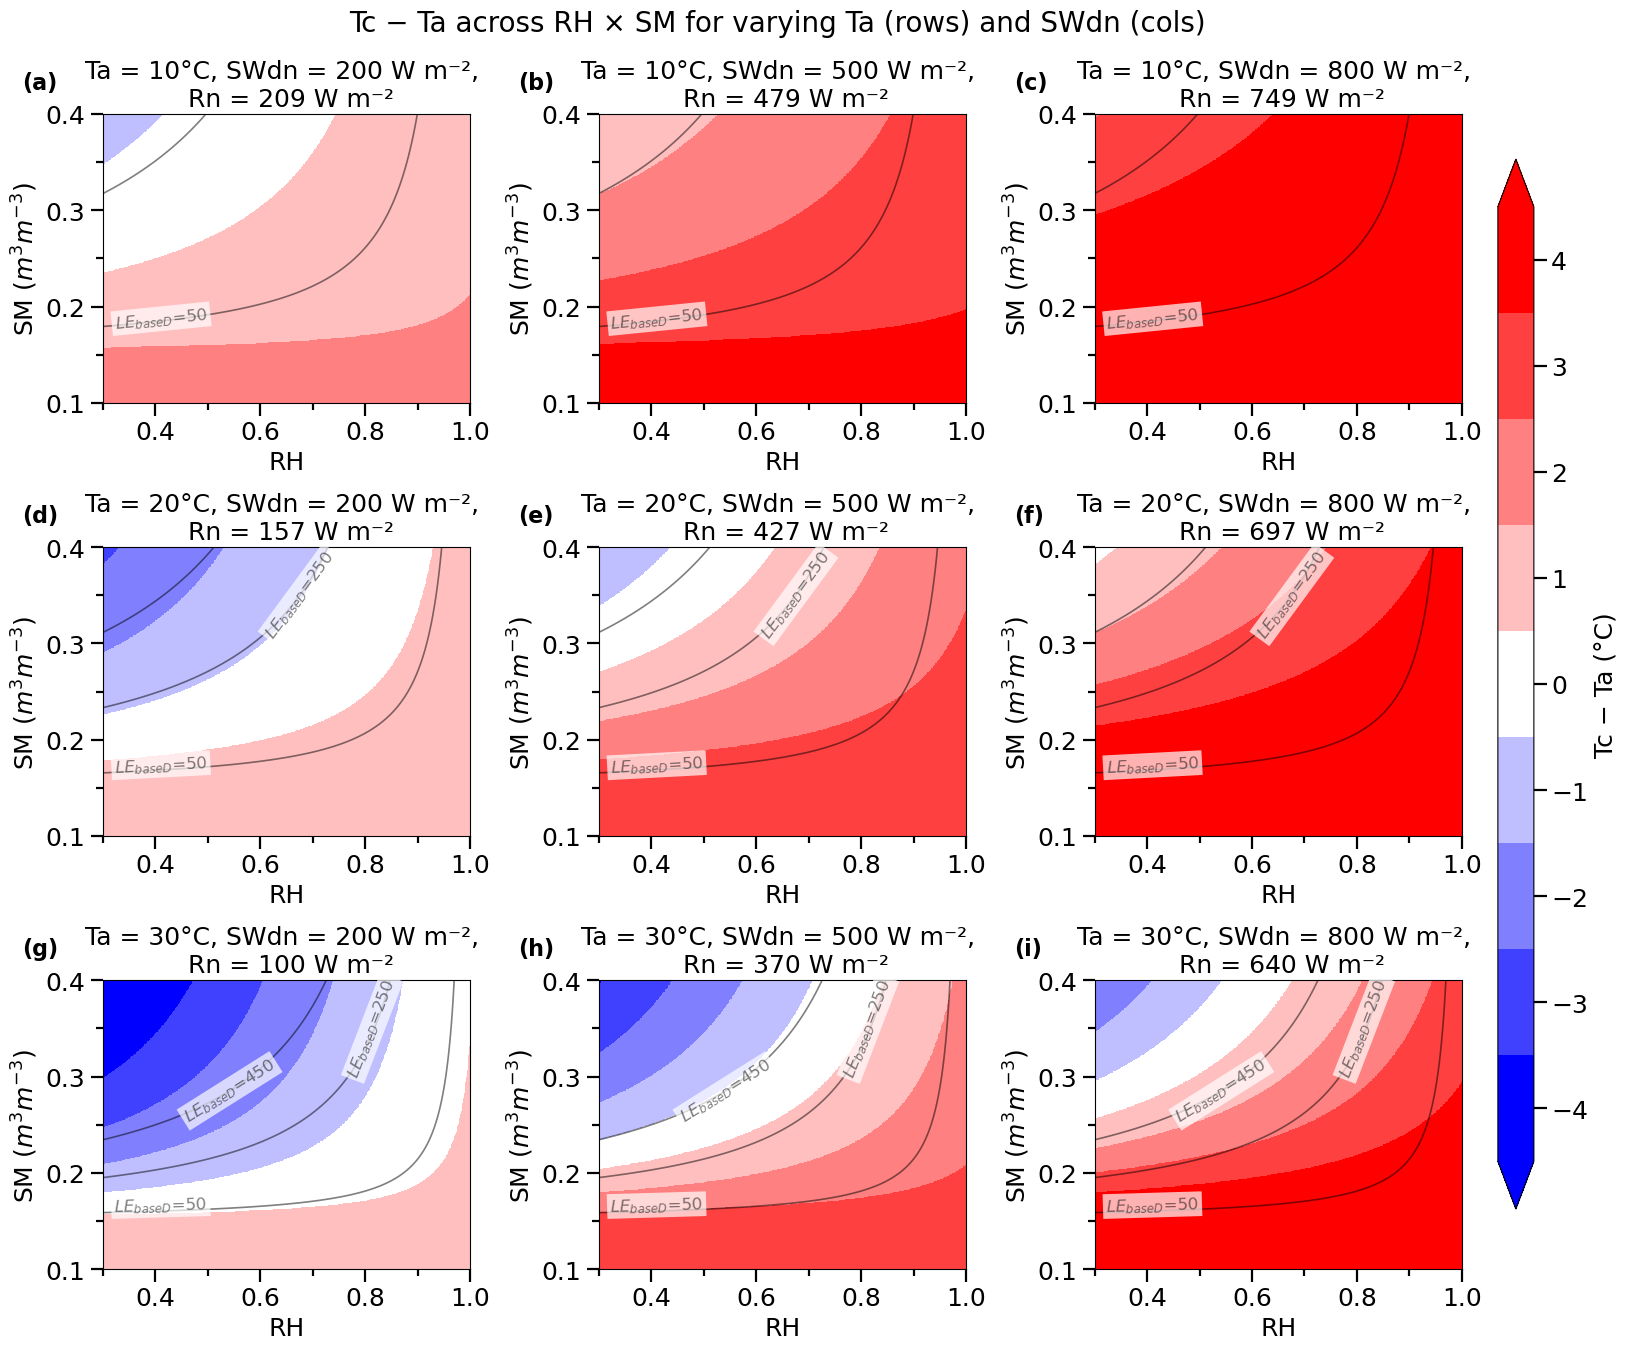

In [8]:
# =========================
# User-defined inputs: FIGURE 1 (RH × SM; rows=Ta, cols=SWdn)
# =========================
LAI_input       = 4.0          # [-]
ra_input        = 10.0         # s m^-1
rs_min_input    = 150.0        # s m^-1 (leaf min)
alpha_input     = 0.10         # [-]
pressure_input  = 101000.0     # Pa (NOW the driver)
LWdn_fixed      = 375.0        # W m^-2

# Grids (centers)
RH_vals = np.linspace(0.30, 1.00, 500)
SM_vals = np.linspace(0.10, 0.40, 500)
RH_grid, SM_grid = np.meshgrid(RH_vals, SM_vals)
# Edges for centered cells
RH_edges = centers_to_edges(RH_vals)
SM_edges = centers_to_edges(SM_vals)

# Sweep lists (rows: Ta; cols: SWdn)
Ta_list   = [10.0, 20.0, 30.0]       # °C
SWdn_list = [200.0, 500.0, 800.0]    # W m^-2

# ===== Print iterated densities once (for the Ta list) =====
print(f"Iterated air density ρ (kg m^-3) using pressure={pressure_input/100:.1f} hPa and saturation q:")
for Ta in Ta_list:
    rho_iter = iterate_rho(Ta, pressure_input, RH=None, use_RH_for_rho=False, rho_init=1.15)
    print(f"  Ta = {Ta:>4.1f} °C  ->  ρ = {rho_iter:.4f} kg m^-3")

# =========================
# FIGURE 1: Ts-Ta + rs contours
# =========================
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.subplots_adjust(right=0.88, wspace=0.35, hspace=0.50)

vmin, vmax = -4.5, 4.5
n_color = 9
levels_ticks = np.linspace(-4, 4, n_color)

# rs contour levels (s m^-1)
rs_levels = [50, 250, 450]

for r, Ta in enumerate(Ta_list):
    for c, SWdn in enumerate(SWdn_list):
        ax = axes[r, c]

        # ---- inside the loop over r,c (replace your ts_minus_ta_model call + pcolormesh) ----
        dT, Rn_base, LE_base = ts_minus_ta_model(
            RH=RH_grid, SWdn=SWdn, LWdn=LWdn_fixed, Ta_C=Ta,
            LAI=LAI_input, ra=ra_input, SM=SM_grid, rs_min=rs_min_input,
            alpha=alpha_input, pressure=pressure_input,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )
        
        # Base pcolormesh
        pcm = ax.pcolormesh(
            RH_edges, SM_edges, dT,
            cmap=plt.get_cmap('bwr', n_color),
            shading='auto', vmin=vmin, vmax=vmax
        )

        # # Ts - Ta field (iterate ρ internally)
        # Ts_minus_Ta = ts_minus_ta_model(
        #     RH=RH_grid, SWdn=SWdn, LWdn=LWdn_fixed, Ta_C=Ta,
        #     LAI=LAI_input, ra=ra_input, SM=SM_grid, rs_min=rs_min_input,
        #     alpha=alpha_input, pressure=pressure_input,
        #     rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
        #     rho_init=1.15, include_LWup_in_base=True
        # )

        # # Base pcolormesh
        # pcm = ax.pcolormesh(
        #     RH_edges, SM_edges, Ts_minus_Ta,
        #     cmap=plt.get_cmap('bwr', n_color),
        #     shading='auto', vmin=vmin, vmax=vmax
        # )

        # # ---- rs contour overlay (rs depends on SM only here) ----
        # fsm = f_soil_moisture(SM_grid)
        # rs_canopy = rs_min_input / (LAI_input * fsm)    # s m^-1
        # rs_plot = np.clip(rs_canopy, 0, 2000)

        cs = ax.contour(
            RH_grid, SM_grid, LE_base,
            levels=rs_levels, colors='k', linewidths=1.2, alpha=0.5
        )
        # Draw labels without inlining so lines remain continuous
        cl = ax.clabel(cs, fmt=r"$LE_{baseD}$=%d", inline=False, fontsize=12, colors='k')
        
        # Solid white box behind each label (square or rounded)
        for txt in cl:
            txt.set_bbox(dict(
                boxstyle="square,pad=0.18",   # try "round,pad=0.22" for rounded corners
                facecolor="white",
                edgecolor="none",             # or a thin outline: edgecolor="0.7", linewidth=0.5
                linewidth=0.0,
                alpha=0.7                     # tweak if you want a hint of the line to show through
            ))
            # Keep everything inside the subplot and above the contours
            txt.set_clip_on(True)
            txt.set_clip_path(ax.patch)
            txt.set_zorder(3)
        
        # --- Pull labels inward if too close to the edges (continuity preserved) ---
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        mx = 0.13 * (x1 - x0)   # 3% margins
        my = 0.13 * (y1 - y0)
        cx, cy = 0.5*(x0+x1), 0.5*(y0+y1)
        
        for txt in cl:
            x, y = txt.get_position()
            nx, ny = x, y
        
            # clamp into a safe inset box
            if x < x0 + mx: nx = x0 + mx
            if x > x1 - mx: nx = x1 - mx
            if y < y0 + my: ny = y0 + my
            if y > y1 - my: ny = y1 - my
        
            # gentle nudge toward subplot center so labels don't hug the edge
            if (nx != x) or (ny != y):
                vx, vy = cx - nx, cy - ny
                L = (vx**2 + vy**2)**0.5 or 1.0
                extra = 0.03 * max(x1 - x0, y1 - y0)  # 1% of axis span
                nx += extra * vx / L
                ny += extra * vy / L
        
            txt.set_position((nx, ny))

        # # ---- inside the loop over r,c (replace your ts_minus_ta_model call + pcolormesh) ----
        # dT, Rn_base, LE_base = ts_minus_ta_model(
        #     RH=RH_grid, SWdn=SWdn, LWdn=LWdn_fixed, Ta_C=Ta,
        #     LAI=LAI_input, ra=ra_input, SM=SM_grid, rs_min=rs_min_input,
        #     alpha=alpha_input, pressure=pressure_input,
        #     rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
        #     rho_init=1.15, include_LWup_in_base=True
        # )
        
        # # Base pcolormesh (colors unchanged)
        # pcm = ax.pcolormesh(
        #     RH_edges, SM_edges, dT,
        #     cmap=plt.get_cmap('bwr', n_color),
        #     shading='auto', vmin=vmin, vmax=vmax
        # )
        
        # Add Rn_base as an on-plot annotation (stays inside subplot)
        # ax.text(
        #     0.98, 0.02, fr"$Rn$ = {Rn_base:.0f} W m$^{{-2}}$",
        #     transform=ax.transAxes, ha="right", va="bottom", fontsize=14,
        #     color="black",
        #     bbox=dict(boxstyle="round,pad=0.18", facecolor="white", edgecolor="none", alpha=0.85)
        # )


        # Labels / ticks
        ax.set_title(f"Ta = {Ta:.0f}°C, SWdn = {SWdn:.0f} W m⁻², \n Rn = {Rn_base:.0f} W m⁻²", fontsize=TITLE_FS)
        ax.set_xlabel("RH", fontsize=AX_LABEL_FS)
        ax.set_ylabel("SM $(m^{3} m^{-3})$", fontsize=AX_LABEL_FS)
        ax.set_xlim(RH_vals[0], RH_vals[-1])
        ax.set_ylim(SM_vals[0], SM_vals[-1])
        ax.tick_params(axis='both', which='major',
                       labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)
        ax.tick_params(axis='both', which='minor',
                       length=MINOR_TICK_LEN, width=TICK_WIDTH)
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Shared colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
cb = fig.colorbar(pcm, cax=cbar_ax, ticks=levels_ticks, extend='both')
cb.set_label("Tc − Ta (°C)", fontsize=AX_LABEL_FS)
cb.ax.tick_params(labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)

# Panel letters
for i, ax in enumerate(axes.flat):
    ax.text(-0.22, 1.15, f"({string.ascii_lowercase[i]})",
            transform=ax.transAxes, fontsize=16, fontweight='bold',
            ha='left', va='top')

plt.suptitle("Tc − Ta across RH × SM for varying Ta (rows) and SWdn (cols)",
             fontsize=20, y=0.95)

filename = "fig_3_theory_Ts_minus_Ta_RH_SM_Ta_SWdn_iterRho_v1_2.png"
fig.savefig(dir_savefig + filename, dpi=400, bbox_inches='tight')
print(f"Saved png: {filename}")
plt.show()


Iterated air density ρ (kg m^-3) using pressure=1010.0 hPa (Figure 2):
  Ta = 10.0 °C  ->  ρ = 1.2371 kg m^-3
  Ta = 20.0 °C  ->  ρ = 1.1898 kg m^-3
  Ta = 30.0 °C  ->  ρ = 1.1419 kg m^-3
Saved png: supplementary_theory_Ts_minus_Ta_LAI_SM_Ta_RH_iterRho_v1.png


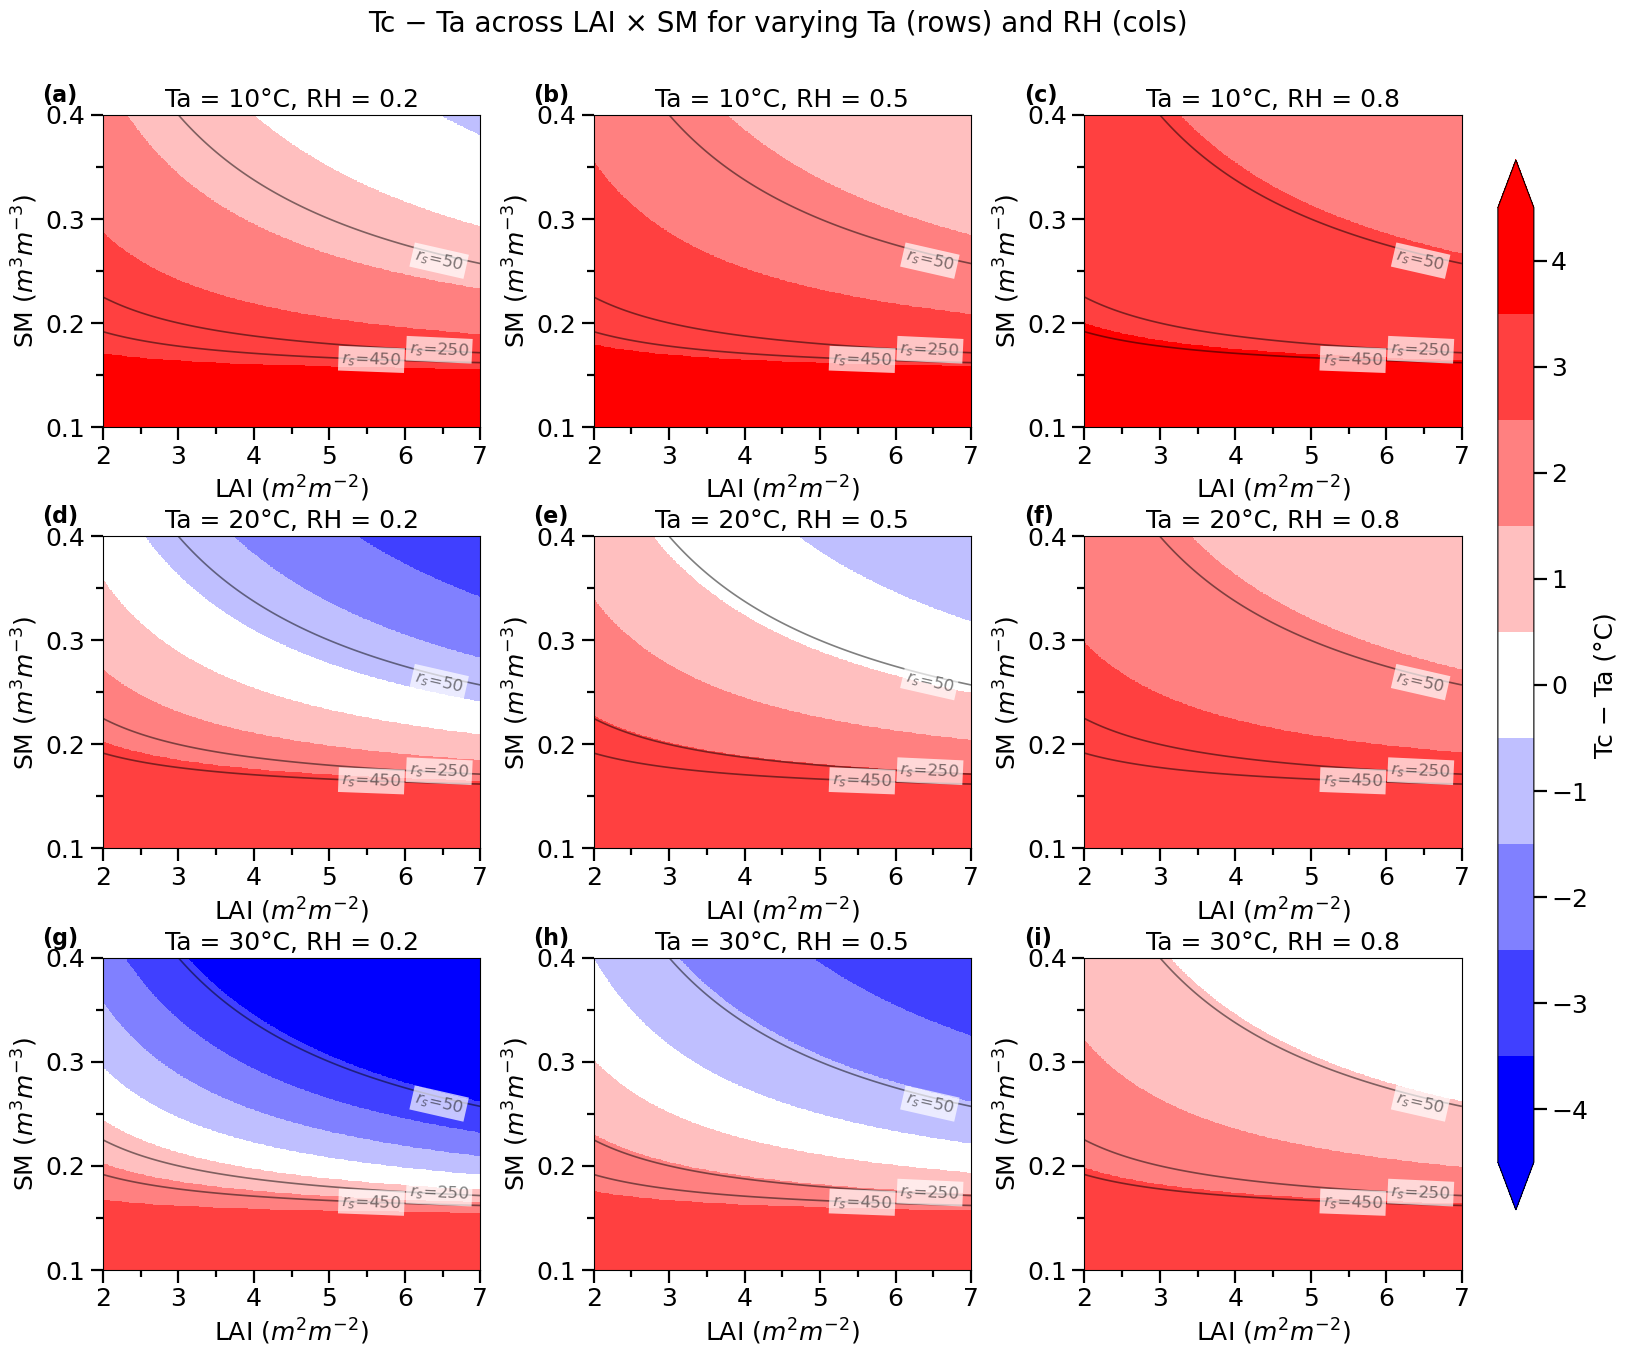

In [9]:
# =========================
# User-defined inputs: FIGURE 2 (LAI × SM; rows=Ta, cols=RH; SWdn=500)
# =========================
SWdn_fixed2 = 500.0
LAI_vals2 = np.linspace(2.0, 7.0, 500)
SM_vals2 = np.linspace(0.10, 0.40, 500)
LAI_grid2, SM_grid2 = np.meshgrid(LAI_vals2, SM_vals2)
LAI_edges2 = centers_to_edges(LAI_vals2)
SM_edges2  = centers_to_edges(SM_vals2)

Ta_list2 = [10.0, 20.0, 30.0]
RH_list2 = [0.2, 0.5, 0.8]

# ===== Print iterated densities once (for the Ta list) =====
print(f"Iterated air density ρ (kg m^-3) using pressure={pressure_input/100:.1f} hPa (Figure 2):")
for Ta in Ta_list2:
    rho_iter = iterate_rho(Ta, pressure_input, RH=None, use_RH_for_rho=False, rho_init=1.15)
    print(f"  Ta = {Ta:>4.1f} °C  ->  ρ = {rho_iter:.4f} kg m^-3")

# =========================
# FIGURE 2: Ts-Ta + rs contours
# =========================
fig2, axes2 = plt.subplots(3, 3, figsize=(18, 15))
fig2.subplots_adjust(right=0.88, wspace=0.30, hspace=0.35)

vmin2, vmax2 = -4.5, 4.5
n_color2 = 9
levels_ticks2 = np.linspace(-4, 4, n_color2)

for r, Ta in enumerate(Ta_list2):
    for c, RH_col in enumerate(RH_list2):
        ax = axes2[r, c]

        Ts_minus_Ta_2, Rn_base, LE_base = ts_minus_ta_model(
            RH=RH_col, SWdn=SWdn_fixed2, LWdn=LWdn_fixed, Ta_C=Ta,
            LAI=LAI_grid2, ra=ra_input, SM=SM_grid2, rs_min=rs_min_input,
            alpha=alpha_input, pressure=pressure_input,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )

        pcm2 = ax.pcolormesh(
            LAI_edges2, SM_edges2, Ts_minus_Ta_2,
            cmap=plt.get_cmap('bwr', n_color2),
            shading='auto', vmin=vmin2, vmax=vmax2
        )

        # ---- rs contour overlay (rs varies with LAI and SM here) ----
        fsm2 = f_soil_moisture(SM_grid2)
        rs_canopy2 = rs_min_input / (LAI_grid2 * fsm2)  # s m^-1
        rs_plot2 = np.clip(rs_canopy2, 0, 2000)

        cs2 = ax.contour(
            LAI_grid2, SM_grid2, rs_plot2,
            levels=rs_levels, colors='k', linewidths=1.2, alpha=0.5
        )
        # Draw labels without inlining so lines remain continuous
        cl2 = ax.clabel(cs2, fmt=r"$r_s$=%d", inline=False, fontsize=12, colors='k')
        
        # Solid white box behind each label (square or rounded)
        for txt in cl2:
            txt.set_bbox(dict(
                boxstyle="square,pad=0.18",   # try "round,pad=0.22" for rounded corners
                facecolor="white",
                edgecolor="none",             # or a thin outline: edgecolor="0.7", linewidth=0.5
                linewidth=0.0,
                alpha=0.7                     # tweak if you want a hint of the line to show through
            ))
            # Keep everything inside the subplot and above the contours
            txt.set_clip_on(True)
            txt.set_clip_path(ax.patch)
            txt.set_zorder(3)
        
        # --- Pull labels inward if too close to the edges (continuity preserved) ---
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        mx = 0.10 * (x1 - x0)   # 3% margins
        my = 0.10 * (y1 - y0)
        cx, cy = 0.5*(x0+x1), 0.5*(y0+y1)
        
        for txt in cl2:
            x, y = txt.get_position()
            nx, ny = x, y
        
            # clamp into a safe inset box
            if x < x0 + mx: nx = x0 + mx
            if x > x1 - mx: nx = x1 - mx
            if y < y0 + my: ny = y0 + my
            if y > y1 - my: ny = y1 - my
        
            # gentle nudge toward subplot center so labels don't hug the edge
            if (nx != x) or (ny != y):
                vx, vy = cx - nx, cy - ny
                L = (vx**2 + vy**2)**0.5 or 1.0
                extra = 0.01 * max(x1 - x0, y1 - y0)  # 1% of axis span
                nx += extra * vx / L
                ny += extra * vy / L
        
            txt.set_position((nx, ny))

        ax.set_title(f"Ta = {Ta:.0f}°C, RH = {RH_col:.1f}",
                     fontsize=TITLE_FS)
        ax.set_xlabel("LAI $(m^{2} m^{-2})$", fontsize=AX_LABEL_FS)
        ax.set_ylabel("SM $(m^{3} m^{-3})$", fontsize=AX_LABEL_FS)
        ax.set_xlim(LAI_vals2[0], LAI_vals2[-1])
        ax.set_ylim(SM_vals2[0], SM_vals2[-1])
        ax.tick_params(axis='both', which='major',
                       labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)
        ax.tick_params(axis='both', which='minor',
                       length=MINOR_TICK_LEN, width=TICK_WIDTH)
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Shared colorbar
cbar_ax2 = fig2.add_axes([0.90, 0.15, 0.02, 0.70])
cb2 = fig2.colorbar(pcm2, cax=cbar_ax2, ticks=levels_ticks2, extend='both')
cb2.set_label("Tc − Ta (°C)", fontsize=AX_LABEL_FS)
cb2.ax.tick_params(labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)

# Panel letters
for i, ax in enumerate(axes2.flat):
    ax.text(-0.16, 1.10, f"({string.ascii_lowercase[i]})",
            transform=ax.transAxes, fontsize=16, fontweight='bold',
            ha='left', va='top')

plt.suptitle("Tc − Ta across LAI × SM for varying Ta (rows) and RH (cols)",
             fontsize=20, y=0.95)

filename2 = "supplementary_theory_Ts_minus_Ta_LAI_SM_Ta_RH_iterRho_v1.png"
fig2.savefig(dir_savefig + filename2, dpi=400, bbox_inches='tight')
print(f"Saved png: {filename2}")
plt.show()


Case 3 (SM series) — central-diff minima:
  SM=0.15: min d(Ts-Ta)/dTa = -0.0505 at Ta=45.0°C
  SM=0.15: Ts-Ta never crosses 0°C in 5–46°C
  SM=0.20: min d(Ts-Ta)/dTa = -0.1539 at Ta=45.0°C
  SM=0.20: Ts-Ta crosses 0°C at Ta ≈ 42.41°C
  SM=0.25: min d(Ts-Ta)/dTa = -0.1818 at Ta=45.0°C
  SM=0.25: Ts-Ta crosses 0°C at Ta ≈ 33.45°C
  SM=0.30: min d(Ts-Ta)/dTa = -0.1881 at Ta=44.0°C
  SM=0.30: Ts-Ta crosses 0°C at Ta ≈ 28.33°C
  SM=0.35: min d(Ts-Ta)/dTa = -0.1905 at Ta=39.0°C
  SM=0.35: Ts-Ta crosses 0°C at Ta ≈ 24.82°C
  SM=0.40: min d(Ts-Ta)/dTa = -0.1922 at Ta=36.0°C
  SM=0.40: Ts-Ta crosses 0°C at Ta ≈ 22.19°C
Saved png: supplementary_theory_dTsTa_dTa_Ta5to46_SMseries_iterRho_v2.png


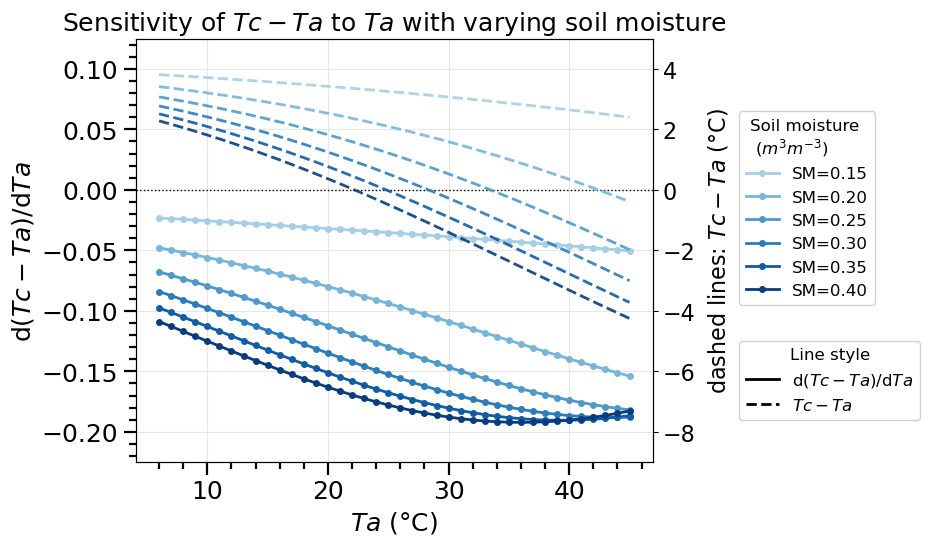

In [10]:
# =========================
# Case 3: central-diff d(Ts-Ta)/dTa (Ta: 5→46°C) — varying SM (blue) + twin y-axis
# =========================

RH_fd       = 0.50
LAI_fd      = 4.0
ra_fd       = 10.0
rs_min_fd   = 200.0
alpha_fd    = 0.10
pressure_fd = pressure_input     # Pa
LWdn_fd     = 375.0
SWdn_fd     = 500.0

# Soil moisture series (sorted; light→dark blue)
SM_list = np.array([0.15, 0.20, 0.25, 0.30, 0.35, 0.40], dtype=float)
SM_list.sort()

# Evaluate Ts-Ta for Ta = 5..46 °C (inclusive)
Ta_eval = np.arange(5.0, 46.0 + 1.0, 1.0)      # 5,6,...,46  (len=42)
Ta_central = Ta_eval[1:-1]                     # 6..45 for central difference (len=40)

fig3, ax3 = plt.subplots(figsize=(9, 5.5))
ax3r = ax3.twinx()

# Light→dark blue ramp
cmap = plt.cm.Blues
colors = cmap(np.linspace(0.35, 0.95, len(SM_list)))

deriv_handles = []
print("Case 3 (SM series) — central-diff minima:")
for i, SM_fd in enumerate(SM_list):
    # Ts-Ta at all Ta_eval points
    TsTa_vals = np.array([
        ts_minus_ta_model(
            RH=RH_fd, SWdn=SWdn_fd, LWdn=LWdn_fd, Ta_C=TaC,
            LAI=LAI_fd, ra=ra_fd, SM=SM_fd, rs_min=rs_min_fd,
            alpha=alpha_fd, pressure=pressure_fd,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )[0]
        for TaC in Ta_eval
    ])

    # Central difference: (f_{i+1} - f_{i-1}) / (2*1°C)
    dTsTa_dTa = (TsTa_vals[2:] - TsTa_vals[:-2]) / 2.0   # length matches Ta_central

    # Primary y: derivative (solid)
    h, = ax3.plot(
        Ta_central, dTsTa_dTa,
        linewidth=2, marker='o', markersize=4,
        color=colors[i], label=f"SM={SM_fd:.2f}"
    )
    deriv_handles.append(h)

    # Twin y: Ts-Ta (dashed), aligned to central-x positions
    ax3r.plot(
        Ta_central, TsTa_vals[1:-1],
        linewidth=2, linestyle='--', marker=None,
        color=colors[i], alpha=0.9
    )

    # Print minimum derivative and Ta
    if np.any(np.isfinite(dTsTa_dTa)):
        j = int(np.nanargmin(dTsTa_dTa))
        print(f"  SM={SM_fd:.2f}: min d(Ts-Ta)/dTa = {dTsTa_dTa[j]:.4f} at Ta={Ta_central[j]:.1f}°C")

    # print Ts-Ta=0 crossings over the full 5–46°C range
    roots = _zero_crossings(Ta_eval, TsTa_vals)
    if len(roots) > 0:
        roots_str = ", ".join(f"{r:.2f}" for r in roots)
        print(f"  SM={SM_fd:.2f}: Ts-Ta crosses 0°C at Ta ≈ {roots_str}°C")
    else:
        print(f"  SM={SM_fd:.2f}: Ts-Ta never crosses 0°C in 5–46°C")

# Cosmetics (axes)
yticks1 = [-0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10]
ax3.set_yticks(yticks1)
ax3.set_ylim(min(yticks1)-0.025, max(yticks1)+0.025)
ax3.axhline(0, linestyle=':', linewidth=1, color='k')
ax3.set_xlabel(r"$Ta$ (°C)", fontsize=AX_LABEL_FS)
ax3.set_ylabel(r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$", fontsize=AX_LABEL_FS)

yticks2 = [-8, -6, -4, -2, 0, 2, 4]
ax3r.set_yticks(yticks2)
ax3r.set_ylim(min(yticks2)-1, max(yticks2)+1)
ax3r.set_ylabel(r"dashed lines: $Tc - Ta$ (°C)", fontsize=AX_LABEL_FS)

ax3.set_title(r"Sensitivity of $Tc - Ta$ to $Ta$ with varying soil moisture",
              fontsize=TITLE_FS)
ax3.grid(True, axis='both', alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)
ax3.tick_params(axis='both', which='minor', length=MINOR_TICK_LEN, width=TICK_WIDTH)
ax3.minorticks_on()
ax3r.tick_params(axis='y', labelsize=TICK_LABEL_FS)

# --- put legends outside without overlapping the right y-ticks ---
# Leave room on the right
fig3.subplots_adjust(right=0.70)

# Push right-axis ticks/label away from the edge
ax3r.tick_params(axis='y', labelsize=TICK_LABEL_FS-2) # , pad=12
ax3r.set_ylabel(ax3r.get_ylabel(), fontsize=AX_LABEL_FS-2, labelpad=8)

leg_series = ax3.legend(
    handles=deriv_handles, title="Soil moisture \n $(m^{3} m^{-3})$",
    loc="center left", bbox_to_anchor=(1.15, 0.60),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
style_handles = [
    Line2D([0], [0], color='k', lw=2, linestyle='-',  label=r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$"),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r"$Tc - Ta$")
]
leg_style = ax3.legend(
    handles=style_handles, title="Line style",
    loc="lower left", bbox_to_anchor=(1.15, 0.08),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
ax3.add_artist(leg_series)

# Save and show
fd_filename = "supplementary_theory_dTsTa_dTa_Ta5to46_SMseries_iterRho_v2.png"
fig3.savefig(
    dir_savefig + fd_filename, dpi=400, bbox_inches='tight',
    bbox_extra_artists=(leg_series, leg_style)
)
print(f"Saved png: {fd_filename}")
plt.show()


Case 4 (RH series, SM=0.35) — central-diff minima:
  RH=0.2: min d(Ts-Ta)/dTa = -0.2698 at Ta=41.0°C
  RH=0.2: Ts-Ta crosses 0°C at Ta ≈ 18.31°C
  RH=0.4: min d(Ts-Ta)/dTa = -0.2169 at Ta=40.0°C
  RH=0.4: Ts-Ta crosses 0°C at Ta ≈ 22.29°C
  RH=0.6: min d(Ts-Ta)/dTa = -0.1642 at Ta=39.0°C
  RH=0.6: Ts-Ta crosses 0°C at Ta ≈ 27.92°C
  RH=0.8: min d(Ts-Ta)/dTa = -0.1122 at Ta=36.0°C
  RH=0.8: Ts-Ta crosses 0°C at Ta ≈ 37.52°C
  RH=1.0: min d(Ts-Ta)/dTa = -0.0626 at Ta=29.0°C
  RH=1.0: Ts-Ta never crosses 0°C in 5–46°C
Saved png: supplementary_theory_dTsTa_dTa_Ta5to46_RHseries_iterRho_v2.png


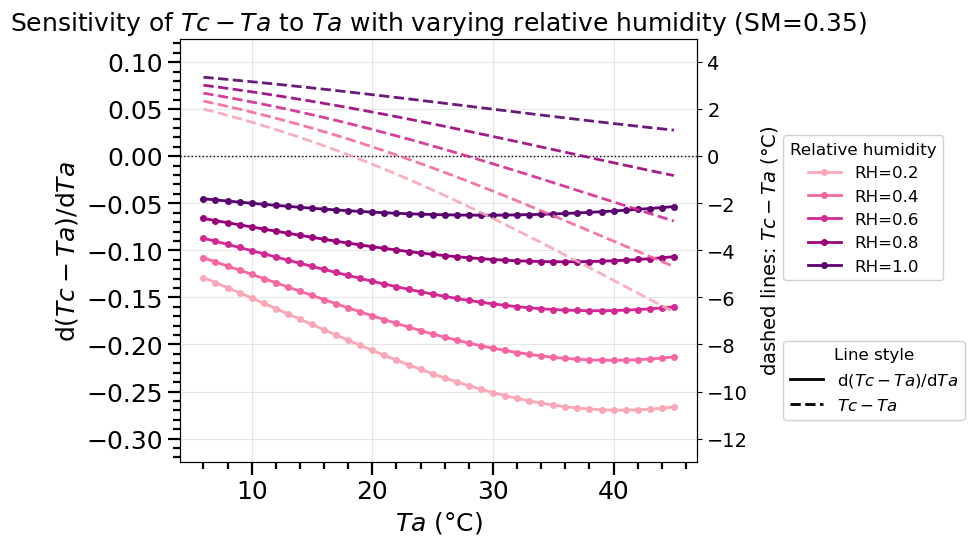

In [11]:
# =========================
# Case 4: central-diff d(Ts-Ta)/dTa (Ta: 5→46°C) — SM=0.35, varying RH (pink) + twin y-axis
# (follows Case 3 figure + print settings)
# =========================
from matplotlib.lines import Line2D

LAI_c4       = 4.0
ra_c4        = 10.0
rs_min_c4    = 200.0
alpha_c4     = 0.10
pressure_c4  = pressure_input     # Pa
LWdn_c4      = 375.0
SWdn_c4      = 500.0
SM_c4        = 0.35

# Relative humidity series (bright→dark pink)
RH_list = np.array([0.2, 0.4, 0.6, 0.8, 1.0], dtype=float)
RH_list.sort()

# Same Ta list as Case 3
Ta_eval    = np.arange(5.0, 46.0 + 1.0, 1.0)   # 5..46 (inclusive)
Ta_central = Ta_eval[1:-1]                     # 6..45 (central-diff x-axis)

fig4, ax4 = plt.subplots(figsize=(9, 5.5))
ax4r = ax4.twinx()

# Bright→dark pink ramp
cmap = plt.cm.RdPu
colors = cmap(np.linspace(0.35, 0.95, len(RH_list)))

deriv_handles = []
print("Case 4 (RH series, SM=0.35) — central-diff minima:")
for i, RH_c4 in enumerate(RH_list):
    # Ts-Ta at all Ta points
    TsTa_vals = np.array([
        ts_minus_ta_model(
            RH=RH_c4, SWdn=SWdn_c4, LWdn=LWdn_c4, Ta_C=TaC,
            LAI=LAI_c4, ra=ra_c4, SM=SM_c4, rs_min=rs_min_c4,
            alpha=alpha_c4, pressure=pressure_c4,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )[0]
        for TaC in Ta_eval
    ])

    # Central difference derivative at Ta_central
    dTsTa_dTa = (TsTa_vals[2:] - TsTa_vals[:-2]) / 2.0

    # Primary y: derivative (solid)
    h, = ax4.plot(
        Ta_central, dTsTa_dTa,
        linewidth=2, marker='o', markersize=4,
        color=colors[i], label=f"RH={RH_c4:.1f}"
    )
    deriv_handles.append(h)

    # Twin y: Ts-Ta (dashed), aligned to central-x positions
    ax4r.plot(
        Ta_central, TsTa_vals[1:-1],
        linewidth=2, linestyle='--', marker=None,
        color=colors[i], alpha=0.9
    )

    # Print minimum derivative and Ta
    if np.any(np.isfinite(dTsTa_dTa)):
        j = int(np.nanargmin(dTsTa_dTa))
        print(f"  RH={RH_c4:.1f}: min d(Ts-Ta)/dTa = {dTsTa_dTa[j]:.4f} at Ta={Ta_central[j]:.1f}°C")

    # print Ts-Ta=0 crossings over the full 5–46°C range
    roots = _zero_crossings(Ta_eval, TsTa_vals)
    if len(roots) > 0:
        roots_str = ", ".join(f"{r:.2f}" for r in roots)
        print(f"  RH={RH_c4:.1f}: Ts-Ta crosses 0°C at Ta ≈ {roots_str}°C")
    else:
        print(f"  RH={RH_c4:.1f}: Ts-Ta never crosses 0°C in 5–46°C")

# ----- Cosmetics (match Case 3) -----
yticks1 = [-0.30, -0.25, -0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10]
ax4.set_yticks(yticks1)
ax4.set_ylim(min(yticks1)-0.025, max(yticks1)+0.025)
ax4.axhline(0, linestyle=':', linewidth=1, color='k')
ax4.set_xlabel(r"$Ta$ (°C)", fontsize=AX_LABEL_FS)
ax4.set_ylabel(r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$", fontsize=AX_LABEL_FS)

yticks2 = [-12, -10,-8, -6, -4, -2, 0, 2, 4]
ax4r.set_yticks(yticks2)
ax4r.set_ylim(min(yticks2)-1, max(yticks2)+1)
ax4r.set_ylabel(r"dashed lines: $Tc - Ta$ (°C)", fontsize=AX_LABEL_FS)

ax4.set_title(r"Sensitivity of $Tc - Ta$ to $Ta$ with varying relative humidity (SM=0.35)",
              fontsize=TITLE_FS)
ax4.grid(True, axis='both', alpha=0.3)
ax4.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)
ax4.tick_params(axis='both', which='minor', length=MINOR_TICK_LEN, width=TICK_WIDTH)
ax4.minorticks_on()
ax4r.tick_params(axis='y', labelsize=TICK_LABEL_FS)

# --- put legends outside without overlapping the right y-ticks ---
fig4.subplots_adjust(right=0.70)
ax4r.tick_params(axis='y', labelsize=TICK_LABEL_FS-4)  # , pad=12 if you want more gap
ax4r.set_ylabel(ax4r.get_ylabel(), fontsize=AX_LABEL_FS-4, labelpad=8)

leg_series = ax4.legend(
    handles=deriv_handles, title="Relative humidity",
    loc="center left", bbox_to_anchor=(1.15, 0.60),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
style_handles = [
    Line2D([0], [0], color='k', lw=2, linestyle='-',  label=r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$"),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r"$Tc - Ta$")
]
leg_style = ax4.legend(
    handles=style_handles, title="Line style",
    loc="lower left", bbox_to_anchor=(1.15, 0.08),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
ax4.add_artist(leg_series)

# Save and show
c4_filename = "supplementary_theory_dTsTa_dTa_Ta5to46_RHseries_iterRho_v2.png"
fig4.savefig(
    dir_savefig + c4_filename, dpi=400, bbox_inches='tight',
    bbox_extra_artists=(leg_series, leg_style)
)
print(f"Saved png: {c4_filename}")
plt.show()


Case 5 (ra series) — central-diff minima:
  ra=  5.0: min d(Tc-Ta)/dTa = -0.1265 at Ta=45.0°C
  ra=  5.0: Tc-Ta crosses 0°C at Ta ≈ 32.93°C
  ra= 10.0: min d(Tc-Ta)/dTa = -0.1818 at Ta=45.0°C
  ra= 10.0: Tc-Ta crosses 0°C at Ta ≈ 33.45°C
  ra= 20.0: min d(Tc-Ta)/dTa = -0.2428 at Ta=37.0°C
  ra= 20.0: Tc-Ta crosses 0°C at Ta ≈ 34.45°C
  ra= 40.0: min d(Tc-Ta)/dTa = -0.3536 at Ta=26.0°C
  ra= 40.0: Tc-Ta crosses 0°C at Ta ≈ 36.23°C
  ra= 80.0: min d(Tc-Ta)/dTa = -0.5521 at Ta=17.0°C
  ra= 80.0: Tc-Ta crosses 0°C at Ta ≈ 39.20°C
Saved png: supplementary_theory_dTsTa_dTa_Ta5to46_raseries_iterRho_v1.png


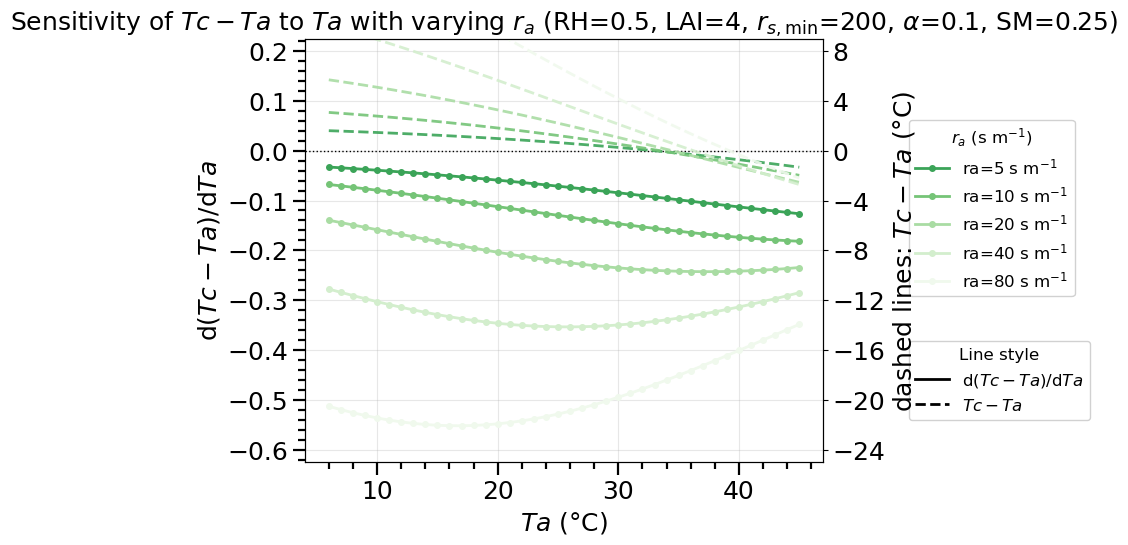

In [12]:
# =========================
# Case 5: central-diff d(Tc-Ta)/dTa (Ta: 5→46°C) — varying ra (green) + twin y-axis
# =========================
RH_c5       = 0.50
LAI_c5      = 4.0
rs_min_c5   = 200.0
alpha_c5    = 0.10
pressure_c5 = 101000.0     # Pa
LWdn_c5     = 375.0        # W m^-2
SWdn_c5     = 500.0        # W m^-2
SM_c5       = 0.25

# Aerodynamic resistance series (small→large; adjust as you like)
ra_list = np.array([5.0, 10.0, 20.0, 40.0, 80.0], dtype=float)

# Same Ta grid as other cases
Ta_eval    = np.arange(5.0, 46.0 + 1.0, 1.0)   # 5..46 (inclusive)
Ta_central = Ta_eval[1:-1]                     # 6..45 for central difference

fig5, ax5 = plt.subplots(figsize=(9, 5.5))
ax5r = ax5.twinx()

# Light→dark green ramp
cmap = plt.cm.Greens_r
colors = cmap(np.linspace(0.35, 0.95, len(ra_list)))

deriv_handles = []
print("Case 5 (ra series) — central-diff minima:")
for i, ra_c5 in enumerate(ra_list):
    # Ts-Ta at all Ta points (take [0] from the tuple return)
    TsTa_vals = np.array([
        ts_minus_ta_model(
            RH=RH_c5, SWdn=SWdn_c5, LWdn=LWdn_c5, Ta_C=TaC,
            LAI=LAI_c5, ra=ra_c5, SM=SM_c5, rs_min=rs_min_c5,
            alpha=alpha_c5, pressure=pressure_c5,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )[0]   # <-- use only dT
        for TaC in Ta_eval
    ])

    # Central difference derivative at Ta_central
    dTsTa_dTa = (TsTa_vals[2:] - TsTa_vals[:-2]) / 2.0

    # Primary y: derivative (solid)
    h, = ax5.plot(
        Ta_central, dTsTa_dTa,
        linewidth=2, marker='o', markersize=4,
        color=colors[i], label=f"ra={ra_c5:.0f} s m$^{{-1}}$"
    )
    deriv_handles.append(h)

    # Twin y: Ts-Ta (dashed), aligned to central-x positions
    ax5r.plot(
        Ta_central, TsTa_vals[1:-1],
        linewidth=2, linestyle='--', marker=None,
        color=colors[i], alpha=0.9
    )

    # Print minimum derivative and Ta
    if np.any(np.isfinite(dTsTa_dTa)):
        j = int(np.nanargmin(dTsTa_dTa))
        print(f"  ra={ra_c5:>5.1f}: min d(Tc-Ta)/dTa = {dTsTa_dTa[j]:.4f} at Ta={Ta_central[j]:.1f}°C")

    # Print Tc−Ta = 0 crossings on full 5–46°C range
    roots = _zero_crossings(Ta_eval, TsTa_vals)
    if len(roots) > 0:
        roots_str = ", ".join(f"{r:.2f}" for r in roots)
        print(f"  ra={ra_c5:>5.1f}: Tc-Ta crosses 0°C at Ta ≈ {roots_str}°C")
    else:
        print(f"  ra={ra_c5:>5.1f}: Tc-Ta never crosses 0°C in 5–46°C")

# ----- Cosmetics (match style of Cases 3 & 4) -----
yticks1 = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2]
ax5.set_yticks(yticks1)
ax5.set_ylim(min(yticks1)-0.025, max(yticks1)+0.025)
ax5.axhline(0, linestyle=':', linewidth=1, color='k')

ax5.set_xlabel(r"$Ta$ (°C)", fontsize=AX_LABEL_FS)
ax5.set_ylabel(r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$", fontsize=AX_LABEL_FS)

yticks2 = [-24, -20, -16, -12, -8, -4, 0, 4, 8]
ax5r.set_yticks(yticks2)
ax5r.set_ylim(min(yticks2)-1, max(yticks2)+1)
ax5r.set_ylabel(r"dashed lines: $Tc - Ta$ (°C)", fontsize=AX_LABEL_FS)

ax5.set_title(r"Sensitivity of $Tc - Ta$ to $Ta$ with varying $r_a$ "
              r"(RH=0.5, LAI=4, $r_{s,\min}$=200, $\alpha$=0.1, SM=0.25)",
              fontsize=TITLE_FS)

ax5.grid(True, axis='both', alpha=0.3)
ax5.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FS,
                length=MAJOR_TICK_LEN, width=TICK_WIDTH)
ax5.tick_params(axis='both', which='minor', length=MINOR_TICK_LEN, width=TICK_WIDTH)
ax5.minorticks_on()
ax5r.tick_params(axis='y', labelsize=TICK_LABEL_FS)

# Leave room on the right for legends
fig5.subplots_adjust(right=0.70)

# Legends (series + style)
leg_series = ax5.legend(
    handles=deriv_handles, title=r"$r_a$ (s m$^{-1}$)",
    loc="center left", bbox_to_anchor=(1.15, 0.60),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
style_handles = [
    Line2D([0], [0], color='k', lw=2, linestyle='-',  label=r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$"),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r"$Tc - Ta$")
]
leg_style = ax5.legend(
    handles=style_handles, title="Line style",
    loc="lower left", bbox_to_anchor=(1.15, 0.08),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
ax5.add_artist(leg_series)

# Save and show
c5_filename = "supplementary_theory_dTsTa_dTa_Ta5to46_raseries_iterRho_v1.png"
fig5.savefig(
    dir_savefig + c5_filename, dpi=400, bbox_inches='tight',
    bbox_extra_artists=(leg_series, leg_style)
)
print(f"Saved png: {c5_filename}")
plt.show()


Case 5: Using rc (canopy resistance) = 125.00 s m^-1 from LAI=4.0, rs_min=200.0, SM=0.25 (fsm=0.400)
Case 5 (ra series, labeled by rc/ra) — central-diff minima:
  ra=   5.0: min d(Tc-Ta)/dTa = -0.1265 at Ta=45.0°C (rs/ra=25.00)
  ra=   5.0: Tc-Ta crosses 0°C at Ta ≈ 32.93°C
  ra=  10.0: min d(Tc-Ta)/dTa = -0.1818 at Ta=45.0°C (rs/ra=12.50)
  ra=  10.0: Tc-Ta crosses 0°C at Ta ≈ 33.45°C
  ra=  20.0: min d(Tc-Ta)/dTa = -0.2428 at Ta=37.0°C (rs/ra=6.25)
  ra=  20.0: Tc-Ta crosses 0°C at Ta ≈ 34.45°C
  ra=  40.0: min d(Tc-Ta)/dTa = -0.3536 at Ta=26.0°C (rs/ra=3.12)
  ra=  40.0: Tc-Ta crosses 0°C at Ta ≈ 36.23°C
  ra=  80.0: min d(Tc-Ta)/dTa = -0.5521 at Ta=17.0°C (rs/ra=1.56)
  ra=  80.0: Tc-Ta crosses 0°C at Ta ≈ 39.20°C
Saved png: supplementary_theory_dTsTa_dTa_Ta5to46_raseries_rc_over_ra_labels.png


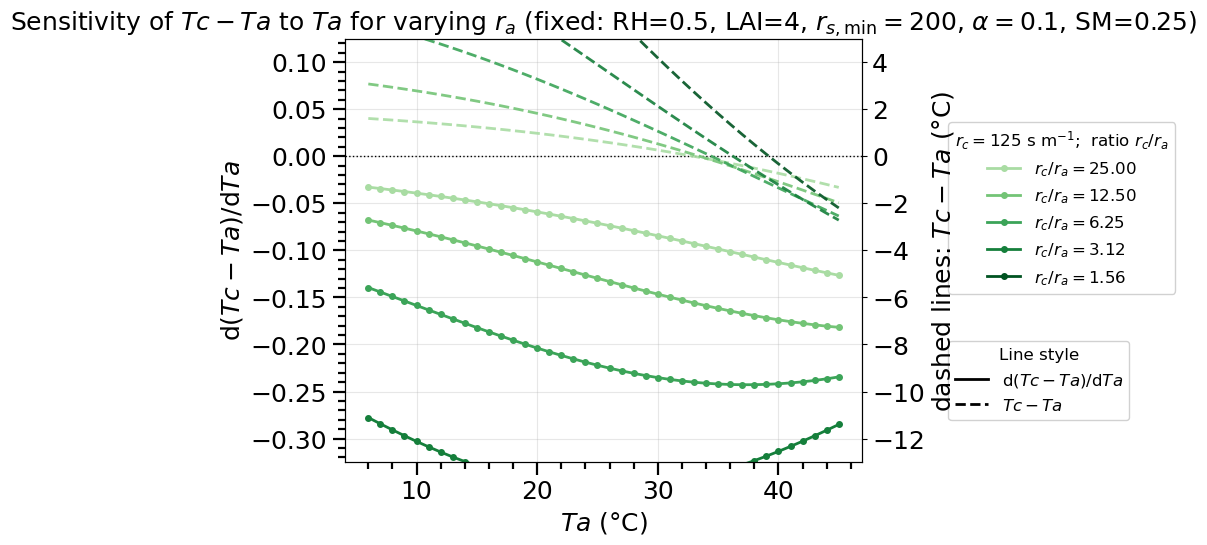

In [13]:
# =========================
# Case 5: central-diff d(Tc-Ta)/dTa (Ta: 5→46°C) — varying ra (green) + twin y-axis
# =========================
RH_c5       = 0.50
LAI_c5      = 4.0
rs_min_c5   = 200.0
alpha_c5    = 0.10
pressure_c5 = 101000.0     # Pa
LWdn_c5     = 375.0        # W m^-2
SWdn_c5     = 500.0        # W m^-2
SM_c5       = 0.25

# Aerodynamic resistance series (s m^-1)
ra_list = np.array([5.0, 10.0, 20.0, 40.0, 80.0], dtype=float)

# Fixed canopy resistance for this case: rc = rs_min/(LAI * f(SM))
fsm_c5 = f_soil_moisture(SM_c5)
rc_c5  = rs_min_c5 / (LAI_c5 * fsm_c5)
print(f"Case 5: Using rc (canopy resistance) = {rc_c5:.2f} s m^-1 "
      f"from LAI={LAI_c5}, rs_min={rs_min_c5}, SM={SM_c5} (fsm={fsm_c5:.3f})")

# Ta grid
Ta_eval    = np.arange(5.0, 46.0 + 1.0, 1.0)   # 5..46 (inclusive)
Ta_central = Ta_eval[1:-1]                     # 6..45 for central difference

fig5, ax5 = plt.subplots(figsize=(9, 5.5))
ax5r = ax5.twinx()

# Light→dark green ramp
cmap = plt.cm.Greens
colors = cmap(np.linspace(0.35, 0.95, len(ra_list)))

deriv_handles = []
print("Case 5 (ra series, labeled by rc/ra) — central-diff minima:")
for i, ra_c5 in enumerate(ra_list):
    # Ts-Ta at all Ta (use [0] to select dT from model return)
    TsTa_vals = np.array([
        ts_minus_ta_model(
            RH=RH_c5, SWdn=SWdn_c5, LWdn=LWdn_c5, Ta_C=TaC,
            LAI=LAI_c5, ra=ra_c5, SM=SM_c5, rs_min=rs_min_c5,
            alpha=alpha_c5, pressure=pressure_c5,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )[0]
        for TaC in Ta_eval
    ])

    # Central difference derivative
    dTsTa_dTa = (TsTa_vals[2:] - TsTa_vals[:-2]) / 2.0

    # Label as rc/ra
    ratio = rc_c5 / ra_c5
    label_str = rf"$r_c/r_a={ratio:.2f}$"

    # Primary y: derivative (solid)
    h, = ax5.plot(
        Ta_central, dTsTa_dTa,
        linewidth=2, marker='o', markersize=4,
        color=colors[i], label=label_str
    )
    deriv_handles.append(h)

    # Twin y: Ts-Ta (dashed)
    ax5r.plot(
        Ta_central, TsTa_vals[1:-1],
        linewidth=2, linestyle='--',
        color=colors[i], alpha=0.9
    )

    # Print minima and zero-crossings
    if np.any(np.isfinite(dTsTa_dTa)):
        j = int(np.nanargmin(dTsTa_dTa))
        print(f"  ra={ra_c5:>6.1f}: min d(Tc-Ta)/dTa = {dTsTa_dTa[j]:.4f} at Ta={Ta_central[j]:.1f}°C "
              f"(rs/ra={ratio:.2f})")

    roots = _zero_crossings(Ta_eval, TsTa_vals)
    if len(roots) > 0:
        roots_str = ", ".join(f"{r:.2f}" for r in roots)
        print(f"  ra={ra_c5:>6.1f}: Tc-Ta crosses 0°C at Ta ≈ {roots_str}°C")
    else:
        print(f"  ra={ra_c5:>6.1f}: Tc-Ta never crosses 0°C in 5–46°C")

# ----- Cosmetics (match your style) -----
yticks1 = [-0.30, -0.25, -0.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10]
ax5.set_yticks(yticks1)
ax5.set_ylim(min(yticks1)-0.025, max(yticks1)+0.025)
ax5.axhline(0, linestyle=':', linewidth=1, color='k')

ax5.set_xlabel(r"$Ta$ (°C)", fontsize=AX_LABEL_FS)
ax5.set_ylabel(r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$", fontsize=AX_LABEL_FS)

yticks2 = [-12, -10, -8, -6, -4, -2, 0, 2, 4]
ax5r.set_yticks(yticks2)
ax5r.set_ylim(min(yticks2)-1, max(yticks2)+1)
ax5r.set_ylabel(r"dashed lines: $Tc - Ta$ (°C)", fontsize=AX_LABEL_FS)

ax5.set_title(r"Sensitivity of $Tc - Ta$ to $Ta$ for varying $r_a$ "
              r"(fixed: RH=0.5, LAI=4, $r_{s,\min}=200$, $\alpha=0.1$, SM=0.25)",
              fontsize=TITLE_FS)

ax5.grid(True, axis='both', alpha=0.3)
ax5.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FS,
                length=MAJOR_TICK_LEN, width=TICK_WIDTH)
ax5.tick_params(axis='both', which='minor', length=MINOR_TICK_LEN, width=TICK_WIDTH)
ax5.minorticks_on()
ax5r.tick_params(axis='y', labelsize=TICK_LABEL_FS)

# Space on the right for legends
fig5.subplots_adjust(right=0.70)

# Legends: series labeled by rc/ra + style legend
leg_series = ax5.legend(
    handles=deriv_handles, title=rf"$r_c={rc_c5:.0f}$ s m$^{{-1}}$;  ratio $r_c/r_a$",
    loc="center left", bbox_to_anchor=(1.15, 0.60),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
style_handles = [
    Line2D([0], [0], color='k', lw=2, linestyle='-',  label=r"$\mathrm{d}(Tc - Ta)/\mathrm{d}Ta$"),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r"$Tc - Ta$")
]
leg_style = ax5.legend(
    handles=style_handles, title="Line style",
    loc="lower left", bbox_to_anchor=(1.15, 0.08),
    frameon=True, framealpha=0.9, fontsize=12, title_fontsize=12
)
ax5.add_artist(leg_series)

# Save and show
c5_filename = "supplementary_theory_dTsTa_dTa_Ta5to46_raseries_rc_over_ra_labels.png"
fig5.savefig(
    dir_savefig + c5_filename, dpi=400, bbox_inches='tight',
    bbox_extra_artists=(leg_series, leg_style)
)
print(f"Saved png: {c5_filename}")
plt.show()


Iterated air density ρ (kg m^-3) using pressure=1010.0 hPa and saturation q:
  Ta = 10.0 °C  ->  ρ = 1.2371 kg m^-3
  Ta = 20.0 °C  ->  ρ = 1.1898 kg m^-3
  Ta = 30.0 °C  ->  ρ = 1.1419 kg m^-3
Saved png: supplementary_theory_Ts_minus_Ta_RH_SM_Ta_ra_iterRho_v1.png


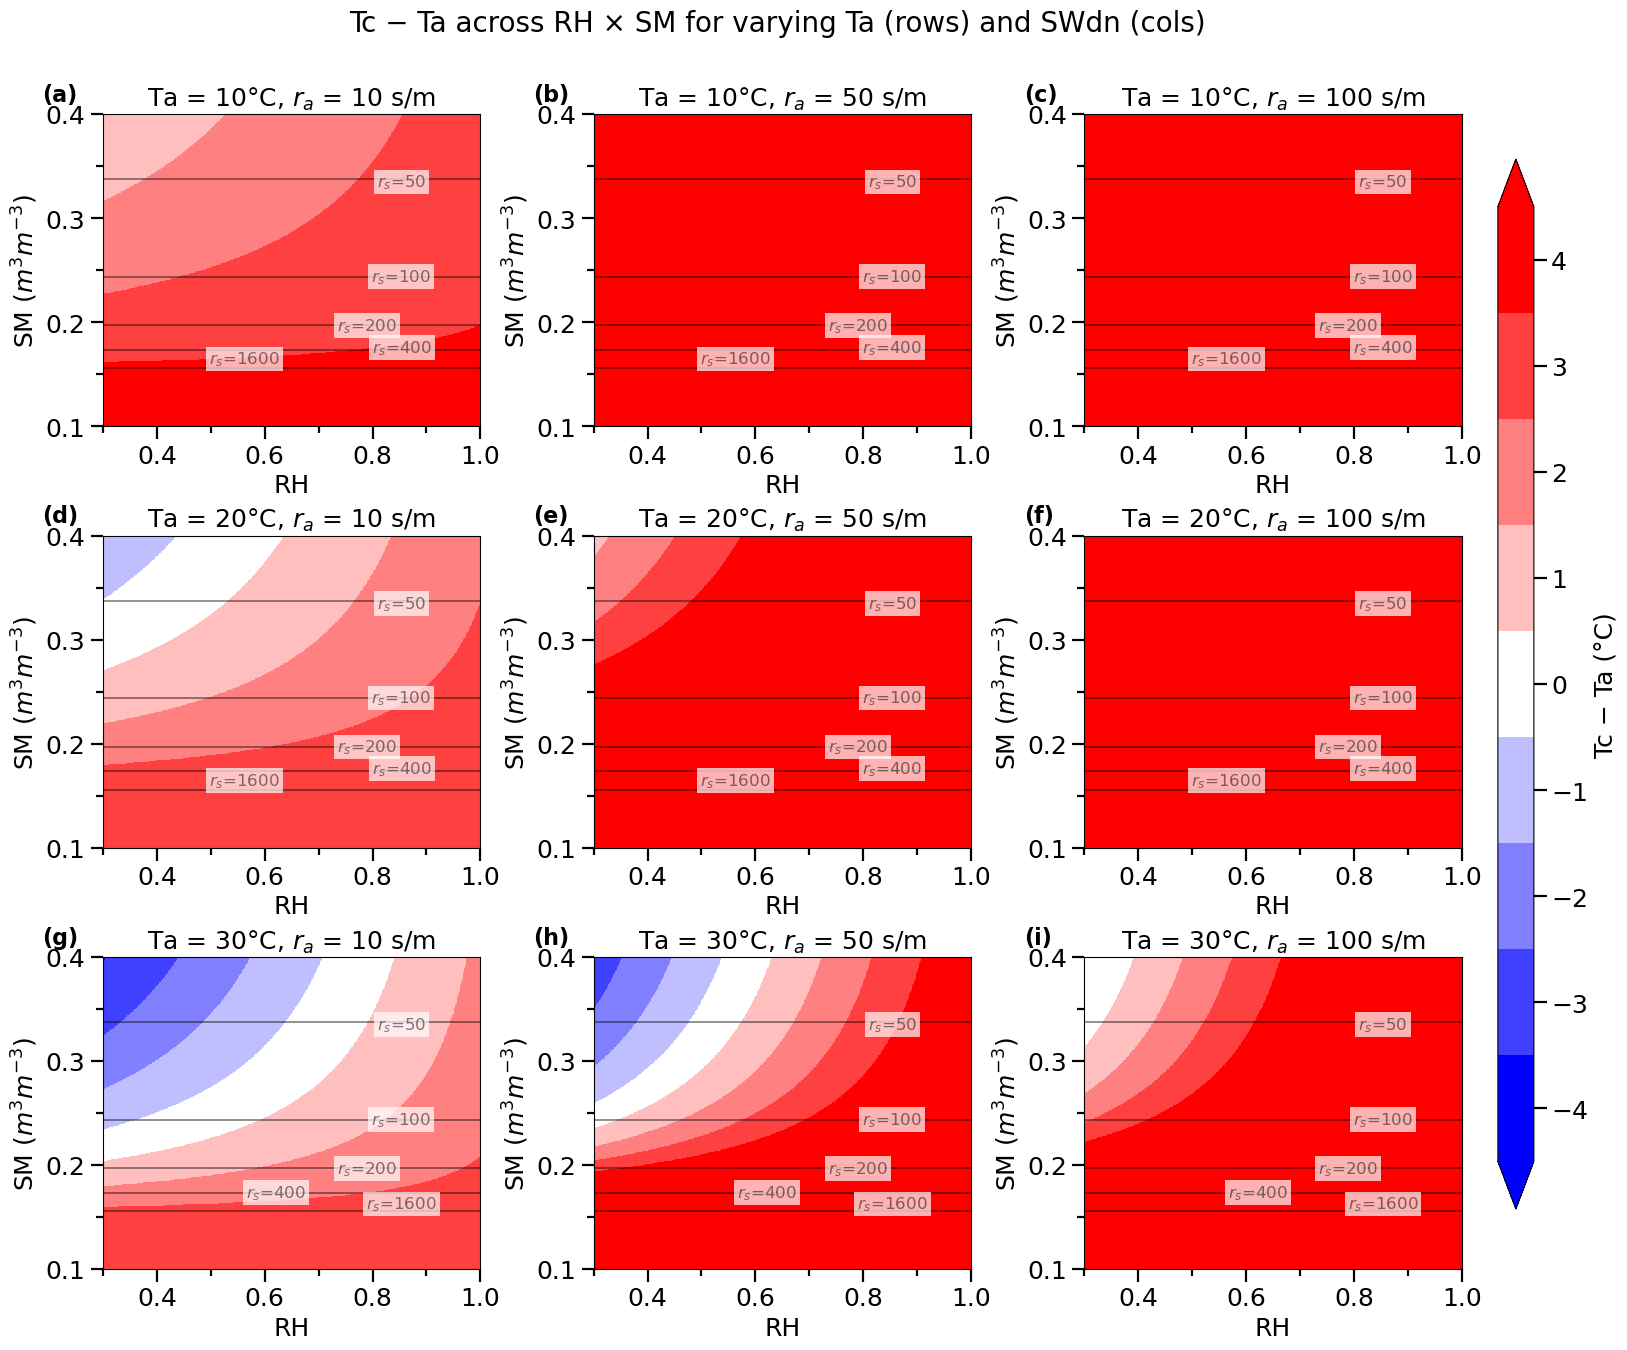

In [14]:
# =========================
# User-defined inputs: FIGURE 1 (RH × SM; rows=Ta, cols=SWdn)
# =========================
LAI_input       = 4.0          # [-]
# ra_input        = 10.0         # s m^-1
rs_min_input    = 150.0        # s m^-1 (leaf min)
alpha_input     = 0.10         # [-]
pressure_input  = 101000.0     # Pa (NOW the driver)
LWdn_fixed      = 375.0        # W m^-2
SWdn_fixed      = 500.0        # W m^-2

# Grids (centers)
RH_vals = np.linspace(0.30, 1.00, 500)
SM_vals = np.linspace(0.10, 0.40, 500)
RH_grid, SM_grid = np.meshgrid(RH_vals, SM_vals)
# Edges for centered cells
RH_edges = centers_to_edges(RH_vals)
SM_edges = centers_to_edges(SM_vals)

# Sweep lists (rows: Ta; cols: SWdn)
Ta_list   = [10.0, 20.0, 30.0]       # °C
ra_list = [10.0, 50.0, 100.0]    # W m^-2

# ===== Print iterated densities once (for the Ta list) =====
print(f"Iterated air density ρ (kg m^-3) using pressure={pressure_input/100:.1f} hPa and saturation q:")
for Ta in Ta_list:
    rho_iter = iterate_rho(Ta, pressure_input, RH=None, use_RH_for_rho=False, rho_init=1.15)
    print(f"  Ta = {Ta:>4.1f} °C  ->  ρ = {rho_iter:.4f} kg m^-3")

# =========================
# FIGURE 1: Ts-Ta + rs contours
# =========================
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.subplots_adjust(right=0.88, wspace=0.30, hspace=0.35)

vmin, vmax = -4.5, 4.5
n_color = 9
levels_ticks = np.linspace(-4, 4, n_color)

# rs contour levels (s m^-1)
rs_levels = [50, 100, 200, 400, 1600]

for r, Ta in enumerate(Ta_list):
    for c, ra in enumerate(ra_list):
        ax = axes[r, c]

        # Ts - Ta field (iterate ρ internally)
        Ts_minus_Ta, Rn, airD = ts_minus_ta_model(
            RH=RH_grid, SWdn=SWdn_fixed, LWdn=LWdn_fixed, Ta_C=Ta,
            LAI=LAI_input, ra=ra, SM=SM_grid, rs_min=rs_min_input,
            alpha=alpha_input, pressure=pressure_input,
            rho=None, iterate_rho_flag=True, use_RH_for_rho=False,
            rho_init=1.15, include_LWup_in_base=True
        )

        # Base pcolormesh
        pcm = ax.pcolormesh(
            RH_edges, SM_edges, Ts_minus_Ta,
            cmap=plt.get_cmap('bwr', n_color),
            shading='auto', vmin=vmin, vmax=vmax
        )

        # ---- rs contour overlay (rs depends on SM only here) ----
        fsm = f_soil_moisture(SM_grid)
        rs_canopy = rs_min_input / (LAI_input * fsm)    # s m^-1
        rs_plot = np.clip(rs_canopy, 0, 2000)

        cs = ax.contour(
            RH_grid, SM_grid, rs_plot,
            levels=rs_levels, colors='k', linewidths=1.2, alpha=0.5
        )
        # Draw labels without inlining so lines remain continuous
        cl = ax.clabel(cs, fmt=r"$r_s$=%d", inline=False, fontsize=12, colors='k')
        
        # Solid white box behind each label (square or rounded)
        for txt in cl:
            txt.set_bbox(dict(
                boxstyle="square,pad=0.18",   # try "round,pad=0.22" for rounded corners
                facecolor="white",
                edgecolor="none",             # or a thin outline: edgecolor="0.7", linewidth=0.5
                linewidth=0.0,
                alpha=0.7                     # tweak if you want a hint of the line to show through
            ))
            # Keep everything inside the subplot and above the contours
            txt.set_clip_on(True)
            txt.set_clip_path(ax.patch)
            txt.set_zorder(3)
        
        # --- Pull labels inward if too close to the edges (continuity preserved) ---
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        mx = 0.20 * (x1 - x0)   # 3% margins
        my = 0.20 * (y1 - y0)
        cx, cy = 0.5*(x0+x1), 0.5*(y0+y1)
        
        for txt in cl:
            x, y = txt.get_position()
            nx, ny = x, y
        
            # clamp into a safe inset box
            if x < x0 + mx: nx = x0 + mx
            if x > x1 - mx: nx = x1 - mx
            if y < y0 + my: ny = y0 + my
            if y > y1 - my: ny = y1 - my
        
            # gentle nudge toward subplot center so labels don't hug the edge
            if (nx != x) or (ny != y):
                vx, vy = cx - nx, cy - ny
                L = (vx**2 + vy**2)**0.5 or 1.0
                extra = 0.01 * max(x1 - x0, y1 - y0)  # 1% of axis span
                nx += extra * vx / L
                ny += extra * vy / L
        
            txt.set_position((nx, ny))

        # Labels / ticks
        ax.set_title(f"Ta = {Ta:.0f}°C, $r_a$ = {ra:.0f} s/m", fontsize=TITLE_FS)
        ax.set_xlabel("RH", fontsize=AX_LABEL_FS)
        ax.set_ylabel("SM $(m^{3} m^{-3})$", fontsize=AX_LABEL_FS)
        ax.set_xlim(RH_vals[0], RH_vals[-1])
        ax.set_ylim(SM_vals[0], SM_vals[-1])
        ax.tick_params(axis='both', which='major',
                       labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)
        ax.tick_params(axis='both', which='minor',
                       length=MINOR_TICK_LEN, width=TICK_WIDTH)
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Shared colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
cb = fig.colorbar(pcm, cax=cbar_ax, ticks=levels_ticks, extend='both')
cb.set_label("Tc − Ta (°C)", fontsize=AX_LABEL_FS)
cb.ax.tick_params(labelsize=TICK_LABEL_FS, length=MAJOR_TICK_LEN, width=TICK_WIDTH)

# Panel letters
for i, ax in enumerate(axes.flat):
    ax.text(-0.16, 1.10, f"({string.ascii_lowercase[i]})",
            transform=ax.transAxes, fontsize=16, fontweight='bold',
            ha='left', va='top')

plt.suptitle("Tc − Ta across RH × SM for varying Ta (rows) and SWdn (cols)",
             fontsize=20, y=0.95)

filename = "supplementary_theory_Ts_minus_Ta_RH_SM_Ta_ra_iterRho_v1.png"
fig.savefig(dir_savefig + filename, dpi=400, bbox_inches='tight')
print(f"Saved png: {filename}")
plt.show()


In [58]:
# --- DIAGNOSTIC VERSION of the core model (same math, with "freeze" toggles) ---
def ts_minus_ta_model_diag(
    RH, SWdn, LWdn, Ta_C, LAI, ra, SM, rs_min, alpha,
    pressure,
    iterate_rho_flag=True, use_RH_for_rho=False, rho_init=1.15,
    include_LWup_in_base=True,
    # --- toggles / reference state ---
    freeze_rho=False,                 # use fixed rho_ref instead of iterating with Ta
    rho_ref=None,                     # if None, computed at T_ref
    freeze_CC=False,                  # use q_s(T_ref) and dq_s/dT(T_ref) instead of T-dependent
    freeze_LW=False,                  # use LW_up(T_ref) instead of T-dependent T^4 in the base term
    freeze_rs=False,                  # use rs_ref instead of rs(SM, LAI)
    rs_ref=None,
    T_ref=20.0                        # reference Ta (°C) for frozen pieces
):
    # --- reference-state quantities ---
    TrefK   = T_ref + 273.15
    qs_ref  = saturation_specific_humidity_cc(T_ref, pressure)
    dqs_ref = dqs_dT(T_ref, pressure)
    LWup_ref = epsilon * sigma * TrefK**4

    # density
    if freeze_rho:
        if rho_ref is None:
            # compute a single rho at T_ref (and optional RH) then reuse
            rho_use = iterate_rho(T_ref, pressure, RH=RH if use_RH_for_rho else None,
                                  use_RH_for_rho=use_RH_for_rho, rho_init=rho_init)
        else:
            rho_use = float(rho_ref)
    else:
        rho_use = iterate_rho(Ta_C, pressure, RH=RH if use_RH_for_rho else None,
                              use_RH_for_rho=use_RH_for_rho, rho_init=rho_init) \
                  if (iterate_rho_flag) else rho_init

    # resistances
    if freeze_rs:
        if rs_ref is None:
            fsm_ref = f_soil_moisture(SM)
            rs_use  = rs_min / (LAI * fsm_ref)
        else:
            rs_use  = float(rs_ref)
    else:
        fsm = f_soil_moisture(SM)
        rs_use = rs_min / (LAI * fsm)

    ra_use = max(ra, 1e-6)
    rs_use = max(rs_use, 1e-6)

    # thermo at Ta (or frozen)
    T_K   = Ta_C + 273.15
    if freeze_CC:
        qs    = qs_ref
        dqsDT = dqs_ref
    else:
        qs    = saturation_specific_humidity_cc(Ta_C, pressure)
        dqsDT = dqs_dT(Ta_C, pressure)

    qa    = RH * qs

    # denominator A
    A = (4.0 * epsilon * sigma * T_K**3) + (rho_use * Lv * dqsDT)/(ra_use + rs_use) + (rho_use * Cp)/ra_use

    # base net radiation: (1-α)SW + LWdn - LWup(Ta)  [optionally freeze LWup]
    LWup_at_Ta = (epsilon * sigma * T_K**4) if (include_LWup_in_base and not freeze_LW) else \
                 (LWup_ref if include_LWup_in_base else 0.0)
    Rn_base = (1.0 - alpha) * SWdn + LWdn - LWup_at_Ta

    # base evaporation
    evap_base = (rho_use * Lv / (ra_use + rs_use)) * (qs - qa)

    return (Rn_base - evap_base) / A


In [60]:
def curvature_index(Ta_vec, y_vec):
    Ta = np.asarray(Ta_vec); y = np.asarray(y_vec)
    # central second difference with 1°C step
    d2 = y[2:] - 2*y[1:-1] + y[:-2]
    return float(np.sqrt(np.nanmean(d2**2)))   # RMS curvature

# Example diagnostic at RH=0.6, SM=0.35 (same Ta grid you already use)
Ta_eval = np.arange(5.0, 46.0 + 1.0, 1.0)
kwargs = dict(RH=0.6, SWdn=500.0, LWdn=375.0, LAI=4.0, ra=10.0,
              SM=0.35, rs_min=200.0, alpha=0.10, pressure=pressure_input)

y_all = np.array([ts_minus_ta_model_diag(Ta_C=Ta, **kwargs) for Ta in Ta_eval])
y_noCC = np.array([ts_minus_ta_model_diag(Ta_C=Ta, freeze_CC=True, **kwargs) for Ta in Ta_eval])
y_noLW = np.array([ts_minus_ta_model_diag(Ta_C=Ta, freeze_LW=True, **kwargs) for Ta in Ta_eval])
y_noRho = np.array([ts_minus_ta_model_diag(Ta_C=Ta, freeze_rho=True, **kwargs) for Ta in Ta_eval])

print("Curvature index (larger = more nonlinear vs Ta):")
print(f"  Baseline      : {curvature_index(Ta_eval, y_all):.3e}")
print(f"  Freeze CC     : {curvature_index(Ta_eval, y_noCC):.3e}")
print(f"  Freeze LW     : {curvature_index(Ta_eval, y_noLW):.3e}")
print(f"  Freeze rho    : {curvature_index(Ta_eval, y_noRho):.3e}")


Curvature index (larger = more nonlinear vs Ta):
  Baseline      : 2.433e-03
  Freeze CC     : 4.930e-04
  Freeze LW     : 2.654e-03
  Freeze rho    : 2.134e-03


In [61]:
# ---------- Curvature metric + helpers ----------
def curvature_index(Ta_vec, y_vec):
    """RMS of the central second difference (1 °C spacing). Larger = more curvature."""
    Ta = np.asarray(Ta_vec); y = np.asarray(y_vec)
    d2 = y[2:] - 2*y[1:-1] + y[:-2]
    return float(np.sqrt(np.nanmean(d2**2)))

def tsTa_curve(Ta_eval, **kwargs):
    """Evaluate Ts-Ta (°C) over the Ta grid using the *diagnostic* model with toggles."""
    return np.array([ts_minus_ta_model_diag(Ta_C=TaC, **kwargs) for TaC in Ta_eval])

def print_ci_report(header, Ta_eval, base_kwargs):
    """Print baseline curvature and the effect of freezing CC/LW/rho."""
    y_base = tsTa_curve(Ta_eval, **base_kwargs)
    y_noCC = tsTa_curve(Ta_eval, **{**base_kwargs, "freeze_CC": True})
    y_noLW = tsTa_curve(Ta_eval, **{**base_kwargs, "freeze_LW": True})
    y_noR  = tsTa_curve(Ta_eval, **{**base_kwargs, "freeze_rho": True})

    ci_b  = curvature_index(Ta_eval, y_base)
    ci_cc = curvature_index(Ta_eval, y_noCC)
    ci_lw = curvature_index(Ta_eval, y_noLW)
    ci_r  = curvature_index(Ta_eval, y_noR)

    def pct_reduction(ci_freeze):
        return (np.nan if ci_b < 1e-12 else 100.0 * (1.0 - ci_freeze/ci_b))

    red_cc, red_lw, red_r = pct_reduction(ci_cc), pct_reduction(ci_lw), pct_reduction(ci_r)

    print(header)
    print(f"  CI baseline   : {ci_b:.3e}")
    print(f"  CI freeze-CC  : {ci_cc:.3e}  (ΔCI {red_cc:+.1f}% vs base)")
    print(f"  CI freeze-LW  : {ci_lw:.3e}  (ΔCI {red_lw:+.1f}% vs base)")
    print(f"  CI freeze-rho : {ci_r :.3e}  (ΔCI {red_r :+.1f}% vs base)")
    if ci_b >= 1e-12:
        reds   = np.array([red_cc, red_lw, red_r], dtype=float)
        labels = np.array(["CC", "LW", "rho"])
        k = int(np.nanargmax(reds))
        print(f"  ⇒ Dominant source (by CI reduction): {labels[k]} ({reds[k]:.1f}%)")
    print()

# ---------- Regime sweeps (same Ta grid you used) ----------
Ta_eval = np.arange(5.0, 46.0 + 1.0, 1.0)  # 5..46 °C (inclusive)

# Common fixed settings (match your Case 3/4 defaults)
COMMON = dict(
    SWdn=500.0, LWdn=375.0, LAI=4.0, ra=10.0,
    rs_min=200.0, alpha=0.10, pressure=pressure_input,
    iterate_rho_flag=True, use_RH_for_rho=False, rho_init=1.15,
    include_LWup_in_base=True
)

# 1) Sweep RH (like your Case 4), fix SM
SM_fix   = 0.35
RH_list  = np.array([0.2, 0.4, 0.6, 0.8, 1.0], dtype=float)
print("=== Curvature attribution across RH (SM fixed) ===")
for RH in RH_list:
    kwargs = dict(RH=RH, SM=SM_fix, **COMMON)
    print_ci_report(f"RH={RH:.1f}, SM={SM_fix:.2f}", Ta_eval, kwargs)

# 2) Sweep SM (like your Case 3), fix RH
RH_fix   = 0.50
SM_list  = np.array([0.15, 0.20, 0.25, 0.30, 0.35, 0.40], dtype=float)
print("=== Curvature attribution across SM (RH fixed) ===")
for SM in SM_list:
    kwargs = dict(RH=RH_fix, SM=SM, **COMMON)
    print_ci_report(f"RH={RH_fix:.2f}, SM={SM:.2f}", Ta_eval, kwargs)

# 3) Sweep SWdn, fix RH & SM (optional)
SW_list = np.array([200.0, 500.0, 800.0], dtype=float)
print("=== Curvature attribution across SW↓ (RH & SM fixed) ===")
for SW in SW_list:
    kwargs = dict(RH=RH_fix, SM=SM_fix, **{**COMMON, "SWdn": SW})
    print_ci_report(f"RH={RH_fix:.2f}, SM={SM_fix:.2f}, SWdn={SW:.0f} W m⁻²", Ta_eval, kwargs)


=== Curvature attribution across RH (SM fixed) ===
RH=0.2, SM=0.35
  CI baseline   : 4.220e-03
  CI freeze-CC  : 4.826e-04  (ΔCI +88.6% vs base)
  CI freeze-LW  : 4.471e-03  (ΔCI -6.0% vs base)
  CI freeze-rho : 3.904e-03  (ΔCI +7.5% vs base)
  ⇒ Dominant source (by CI reduction): CC (88.6%)

RH=0.4, SM=0.35
  CI baseline   : 3.322e-03
  CI freeze-CC  : 4.878e-04  (ΔCI +85.3% vs base)
  CI freeze-LW  : 3.563e-03  (ΔCI -7.2% vs base)
  CI freeze-rho : 3.009e-03  (ΔCI +9.4% vs base)
  ⇒ Dominant source (by CI reduction): CC (85.3%)

RH=0.6, SM=0.35
  CI baseline   : 2.433e-03
  CI freeze-CC  : 4.930e-04  (ΔCI +79.7% vs base)
  CI freeze-LW  : 2.654e-03  (ΔCI -9.1% vs base)
  CI freeze-rho : 2.134e-03  (ΔCI +12.3% vs base)
  ⇒ Dominant source (by CI reduction): CC (79.7%)

RH=0.8, SM=0.35
  CI baseline   : 1.566e-03
  CI freeze-CC  : 4.982e-04  (ΔCI +68.2% vs base)
  CI freeze-LW  : 1.746e-03  (ΔCI -11.5% vs base)
  CI freeze-rho : 1.315e-03  (ΔCI +16.1% vs base)
  ⇒ Dominant source (by C